In [2]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py
import warnings

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from keras.utils import to_categorical
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
sys.path.append('/home1/dscho/code/projects/manning_replication')
from helper_funcs import *
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, place_analysis, pop_decoding

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
_cmap = sns.color_palette('tab10', 10)
_cmap = np.array(_cmap)[(7, 9, 6, 3), :]
_cmap[0, :] *= 1.5
_cmap = _cmap.tolist()

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [ ]:
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------
start_time = time()

# Predict time within each game state, across game states, from population neural activity,
# using support vector classification with nested cross-validation.

# Input params.
y_col = 'iGameStateTime'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
time_steps_per_game_state = {'Delay1': 10,
                             'Encoding': 30,
                             'Delay2': 10,
                             'Retrieval': 30}
# time_steps_per_game_state = {'Delay1': 5,
#                              'Encoding': 15,
#                              'Delay2': 5,
#                              'Retrieval': 15}
n_trials = 36
kfold_inner = 5 # n_trials - 1
search_method = 'random' # 'grid' or 'random'
n_vals_per_hyperparam = 7 # for grid search
n_iter = 100 # for random search
n_jobs = 32 # for running parameter search
save_results = True
overwrite = True
verbose = 0

# Build a processing pipeline.
# 1. Impute missing data by replacing NaNs with their column-wise median.
# 2. Z-score the values in each column.
# 3. Train a support vector classifier with RBF kernel.
pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('svc', SVC(kernel='rbf'))])

# Define a function that sets up parameter search 
# for the inner cross-validation.
def get_bins_per_step(game_state):
    return int(n_time_bins[game_state] / time_steps_per_game_state[game_state])

def setup_param_search():
    """Return an estimator."""
    inner_cv = KFold(kfold_inner)
    
    if search_method == 'grid':    
        param_grid = {'svc__C'     : np.logspace(-5, 5, n_vals_per_hyperparam),
                      'svc__gamma' : np.logspace(-5, 5, n_vals_per_hyperparam)}
        clf = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           refit=True,
                           cv=inner_cv,
                           n_jobs=n_jobs,
                           verbose=verbose)
    elif search_method == 'random':
        param_dist = {'svc__C'     : loguniform(1e-9, 1e9),
                      'svc__gamma' : loguniform(1e-9, 1e9)}
        clf = RandomizedSearchCV(estimator=pipe,
                                 param_distributions=param_dist,
                                 refit=True,
                                 cv=inner_cv,
                                 n_jobs=n_jobs,
                                 n_iter=n_iter)
    return clf

def get_mean_accuracy(acc_vec, reshp):
    """Return mean accuracy across time_bins.
    
    Parameters
    ----------
    acc_vec : list
        Accuracy vector comparing y_test to y_test_pred 
        at each time bin, across test trials.
    reshp : list
        (n_test_trials, n_time_bins)
    """
    return np.mean(np.array(acc_vec).reshape(reshp), axis=0).tolist()

# Select time bins across trials for the current game state.
pop_spikes = pop_decoding.load_pop_spikes()
_pop_spikes = pop_spikes.pop_spikes.query("(gameState=={})".format(game_states)).copy()
neurons = list(pop_spikes.neurons)

# Add a column for game state order.
i_game_states = {'Delay1': 0, 'Encoding': 1, 'Delay2': 2, 'Retrieval': 3}
_pop_spikes.insert(2, 'iGameState', _pop_spikes['gameState'].apply(lambda x: i_game_states[x]).astype(int))

# Aggregate time bins into a defined number of equal-size, larger time steps.
n_time_bins = _pop_spikes.groupby('gameState')['time_bin'].apply(lambda x: len(np.unique(x))).to_dict()
_pop_spikes.insert(3, 'time_step', _pop_spikes.apply(lambda x: int(x['time_bin']/get_bins_per_step(x['gameState'])), axis=1))

# Add a column that combines game state and time step.
_pop_spikes.insert(4, 'gameStateTime', _pop_spikes.apply(lambda x: '{}_{:0>2}'.format(x['iGameState'], x['time_step']), axis=1).astype(str))
i_game_state_times = {gst: igst for (igst, gst) in enumerate(np.unique(_pop_spikes['gameStateTime']))}
_pop_spikes.insert(5, 'iGameStateTime', _pop_spikes['gameStateTime'].apply(lambda x: i_game_state_times[x]).astype(int))
n_time_steps = _pop_spikes['iGameStateTime'].unique().size

# Sort by trial and game state time.
_pop_spikes = _pop_spikes.sort_values(['trial', 'iGameStateTime']).reset_index(drop=True)

# For each unit, sum spikes within each game state time.
_pop_spikes = _pop_spikes.groupby(['trial', 'iGameStateTime'], observed=True)[neurons].apply(np.sum).reset_index()

# Split trials into test and trainval sets.
trials = np.arange(1, n_trials+1).tolist()
test_trainval = []
for trial in trials:
    test = [trial]
    trainval = [trial for trial in trials if trial not in test]
    test_trainval.append([test, trainval])
kfold_outer = len(test_trainval)

# Perform repeated, nested cross-validation, splitting trials into 
# test and nested train/val sets.
clf_results = []
for iFold in range(kfold_outer):
    # Select the test and trainval trials.
    test, trainval = test_trainval[iFold]

    # ---------------------------------
    # Observed data:
    #
    # Split trials into trainval and test sets.
    X_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][neurons].values
    y_test = _pop_spikes.loc[np.isin(_pop_spikes['trial'], test)][y_col].values
    X_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][neurons].values
    y_trainval = _pop_spikes.loc[np.isin(_pop_spikes['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf = setup_param_search()

    # Train the model on trainval data.
    clf.fit(X_trainval, y_trainval)
    best_trainval_score = clf.best_score_
    best_trainval_C = clf.best_params_['svc__C']
    best_trainval_gamma = clf.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred = clf.predict(X_test).tolist()

    # Calculate accuracy.
    accuracy = [y_test_pred[iVal]==y_test[iVal] for iVal in range(len(y_test))]
    acc_by_time = get_mean_accuracy(accuracy, reshp=(len(test), n_time_steps))
    mean_acc = np.mean(accuracy)

    # ---------------------------------
    # Null distribution:
    #
    # Circ-shift time steps within each trial to randomize 
    # time_step ~ pop_spiking associations across trials.
    shuf_idx = np.concatenate(_pop_spikes.reset_index()
                                         .groupby('trial')['index']
                                         .apply(lambda x: np.roll(x, np.random.randint(0, len(x))))
                                         .tolist())
    _pop_spikes_null = _pop_spikes.copy()
    _pop_spikes_null[y_col] = _pop_spikes_null.loc[shuf_idx, y_col].values

    # Split trials into trainval and test sets, using the same split as
    # for the observed data.
    X_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][neurons].values
    y_test_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], test)][y_col].values
    X_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][neurons].values
    y_trainval_null = _pop_spikes_null.loc[np.isin(_pop_spikes_null['trial'], trainval)][y_col].values

    # Setup grid search on the inner CV.
    clf_null = setup_param_search()

    # Train the model on trainval data.
    clf_null.fit(X_trainval_null, y_trainval_null)
    best_trainval_score_null = clf_null.best_score_
    best_trainval_C_null = clf_null.best_params_['svc__C']
    best_trainval_gamma_null = clf_null.best_params_['svc__gamma']

    # Predict time from neural activity on test data.
    y_test_pred_null = clf_null.predict(X_test_null).tolist()

    # Calculate accuracy.
    accuracy_null = [y_test_pred_null[iVal]==y_test_null[iVal] for iVal in range(len(y_test_null))]
    acc_by_time_null = get_mean_accuracy(accuracy_null, reshp=(len(test), n_time_steps))
    mean_acc_null = np.mean(accuracy_null)

    # Append results to the output dataframe.
    clf_results.append([y_col,
                        n_time_steps,
                        test,
                        best_trainval_score,
                        best_trainval_C,
                        best_trainval_gamma,
                        y_test,
                        y_test_pred,
                        mean_acc,
                        acc_by_time,
                        accuracy,
                        best_trainval_score_null,
                        best_trainval_C_null,
                        best_trainval_gamma_null,
                        y_test_null,
                        y_test_pred_null,
                        mean_acc_null,
                        acc_by_time_null,
                        accuracy_null])

cols = ['gameState',
        'n_time_steps',
        'test_trials',
        'best_trainval_score',
        'best_trainval_C',
        'best_trainval_gamma',
        'y_test',
        'y_test_pred',
        'mean_acc',
        'acc_by_time',
        'accuracy',
        'best_trainval_score_null',
        'best_trainval_C_null',
        'best_trainval_gamma_null',
        'y_test_null',
        'y_test_pred_null',
        'mean_acc_null',
        'acc_by_time_null',
        'accuracy_null']
clf_results = pd.DataFrame(clf_results, columns=cols)

if save_results:
    basename = 'SVC_predicting_{}'.format(y_col)
    basename += '-{}units'.format(len(neurons))
    basename += '-{}_search'.format(search_method)
    basename += '-{}bins'.format(n_time_steps)
    basename += '-{}foldin'.format(kfold_inner)
    basename += '-{}foldout'.format(kfold_outer)
    basename += '.pkl'
    filename = op.join(proj_dir, 'analysis', 'classifiers', basename)
    if overwrite or not op.exists(filename):
        dio.save_pickle(clf_results, filename)
        
print('Done in {:.1f} min'.format((time() - start_time)/60))

In [2]:
# Load events.
subj_sess = 'U518_ses1'
proj_dir = '/home1/dscho/projects/time_cells'
overwrite = False
verbose = False
run_all = True

events = events_proc.load_events(subj_sess,
                                 proj_dir=proj_dir,
                                 overwrite=overwrite, 
                                 verbose=verbose,
                                 run_all=run_all)

game_states = ['Delay1', 'Encoding', 'ReturnToBase1', 
               'Delay2', 'Retrieval', 'ReturnToBase2']
game_state_cat = pd.CategoricalDtype(game_states, ordered=True)
events.events_behav['gameState'] = events.events_behav['gameState'].astype(game_state_cat)

print(events)

------------------------------------
U518_ses1
36 trials completed, 34 good

58 gold spawned
52 gold viewed (90%)
32 gold dug (55%)
57 dig attempts (56% accuracy)

dataframe sizes:
	events: (80243, 8)
	event_times: (204, 10)
	positions: (45069, 15)
	base_events: (9016, 7)
	gold_events: (13626, 8)
	gold_spawned: (58, 8)
	dig_events: (57, 8)
	events_behav: (5854, 20)



In [3]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

# for subj_sess in sessions:
#     print(subj_sess)
#     event_spikes = time_bin_analysis.load_event_spikes(subj_sess)
#     time_bin_analysis.save_event_spikes(event_spikes)

7 subjects, 9 sessions


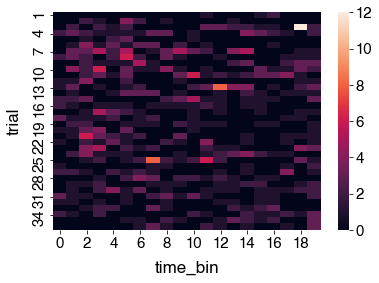

In [285]:
subj_sess = 'U518_ses0'
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)

neuron = '16-2'
sns.heatmap(event_spikes.get_spike_mat(neuron, 'Delay1'))

In [4]:
def get_mean_frs(spike_mat):
    """Return mean firing rate across trials, for each time bin.
    
    Parameters
    ----------
    spike_mat : DataFrame or array
        A trial x time_bin matrix of spike counts.
        
    Returns
    -------
    mean_frs : vector
        Each value is the mean number of spikes for a given time bin.
        For a 500ms time bin, you can get firing rate in Hz by
        multiplying the output of this function by 2.
    """
    mean_frs = np.mean(spike_mat, axis=0)
    return mean_frs

def get_sem_frs(spike_mat):
    """Return mean firing rate across trials, for each time bin.
    
    Parameters
    ----------
    spike_mat : DataFrame or array
        A trial x time_bin matrix of spike counts.
        
    Returns
    -------
    sem_frs : vector
        Each value is the standard error of the mean number of 
        spikes for a given time bin. For a 500ms time bin, you 
        can get SEM firing rate in Hz by multiplying the output 
        of this function by 2.
    """
    sem_frs = stats.sem(spike_mat, axis=0)
    return sem_frs

def get_sparsity(spike_mat):
    """Return sparsity for a trial x time_bin spike matrix.
    
    Ranges from 0 to 1, with smaller values reflecting finer tuning.
    
    See Jung, Wiener & McNaughton, J Neurosci 1994
    """
    mean_frs = get_mean_frs(spike_mat)
    numer = np.square(np.sum(mean_frs)/mean_frs.size)
    denom = np.sum(np.square(mean_frs)/mean_frs.size)
    return numer / denom

def bootstrap_time_fields(spike_mat,
                          z_thresh=2,
                          n_perm=1000):
    """Identify time fields using a bootstrap estimation method.
    
    n_trial values are drawn from spike_mat with replacement, and
    the mean across them is calculated. This is repeated 500 times
    to obtain a sample distribution. Actual mean firing rates across
    trials are then Z-scored against this distribution, and time fields
    are defined as any time bin with a Z-score > z_thresh.
    
    Parameters
    ----------
    spike_mat : DataFrame
        A trial x time_bin matrix of spike counts.
    z_thresh : real number
        Time fields are defined by Z-scored mean firing rates > z_thresh.
        
    Returns
    -------
    cutoff_fr : float
        The firing rate above which values are defined as time fields.
    z_mean_frs : Series
        Z-scored firing rates over time.
    time_field : array[int]
        All time bins with Z-scores > z_thresh.
    """
    n_trial = spike_mat.shape[0]
    mean_frs = np.mean(spike_mat, axis=0)
    spike_vals = spike_mat.values.ravel()
    sample_mean_frs = np.array([np.mean(random.choices(spike_vals, k=n_trial)) for _ in range(n_perm)])
    sample_mean = np.mean(sample_mean_frs)
    sample_std = np.std(sample_mean_frs)
    cutoff_fr = (z_thresh * sample_std) + sample_mean
    z_mean_frs = (mean_frs - sample_mean) / sample_std
    time_field = np.where(z_mean_frs > z_thresh)[0]
    return cutoff_fr, z_mean_frs, time_field

In [5]:
subj_sess = 'U532_ses0'
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)

Delay1 sparsity = 0.966
Delay2 sparsity = 0.917


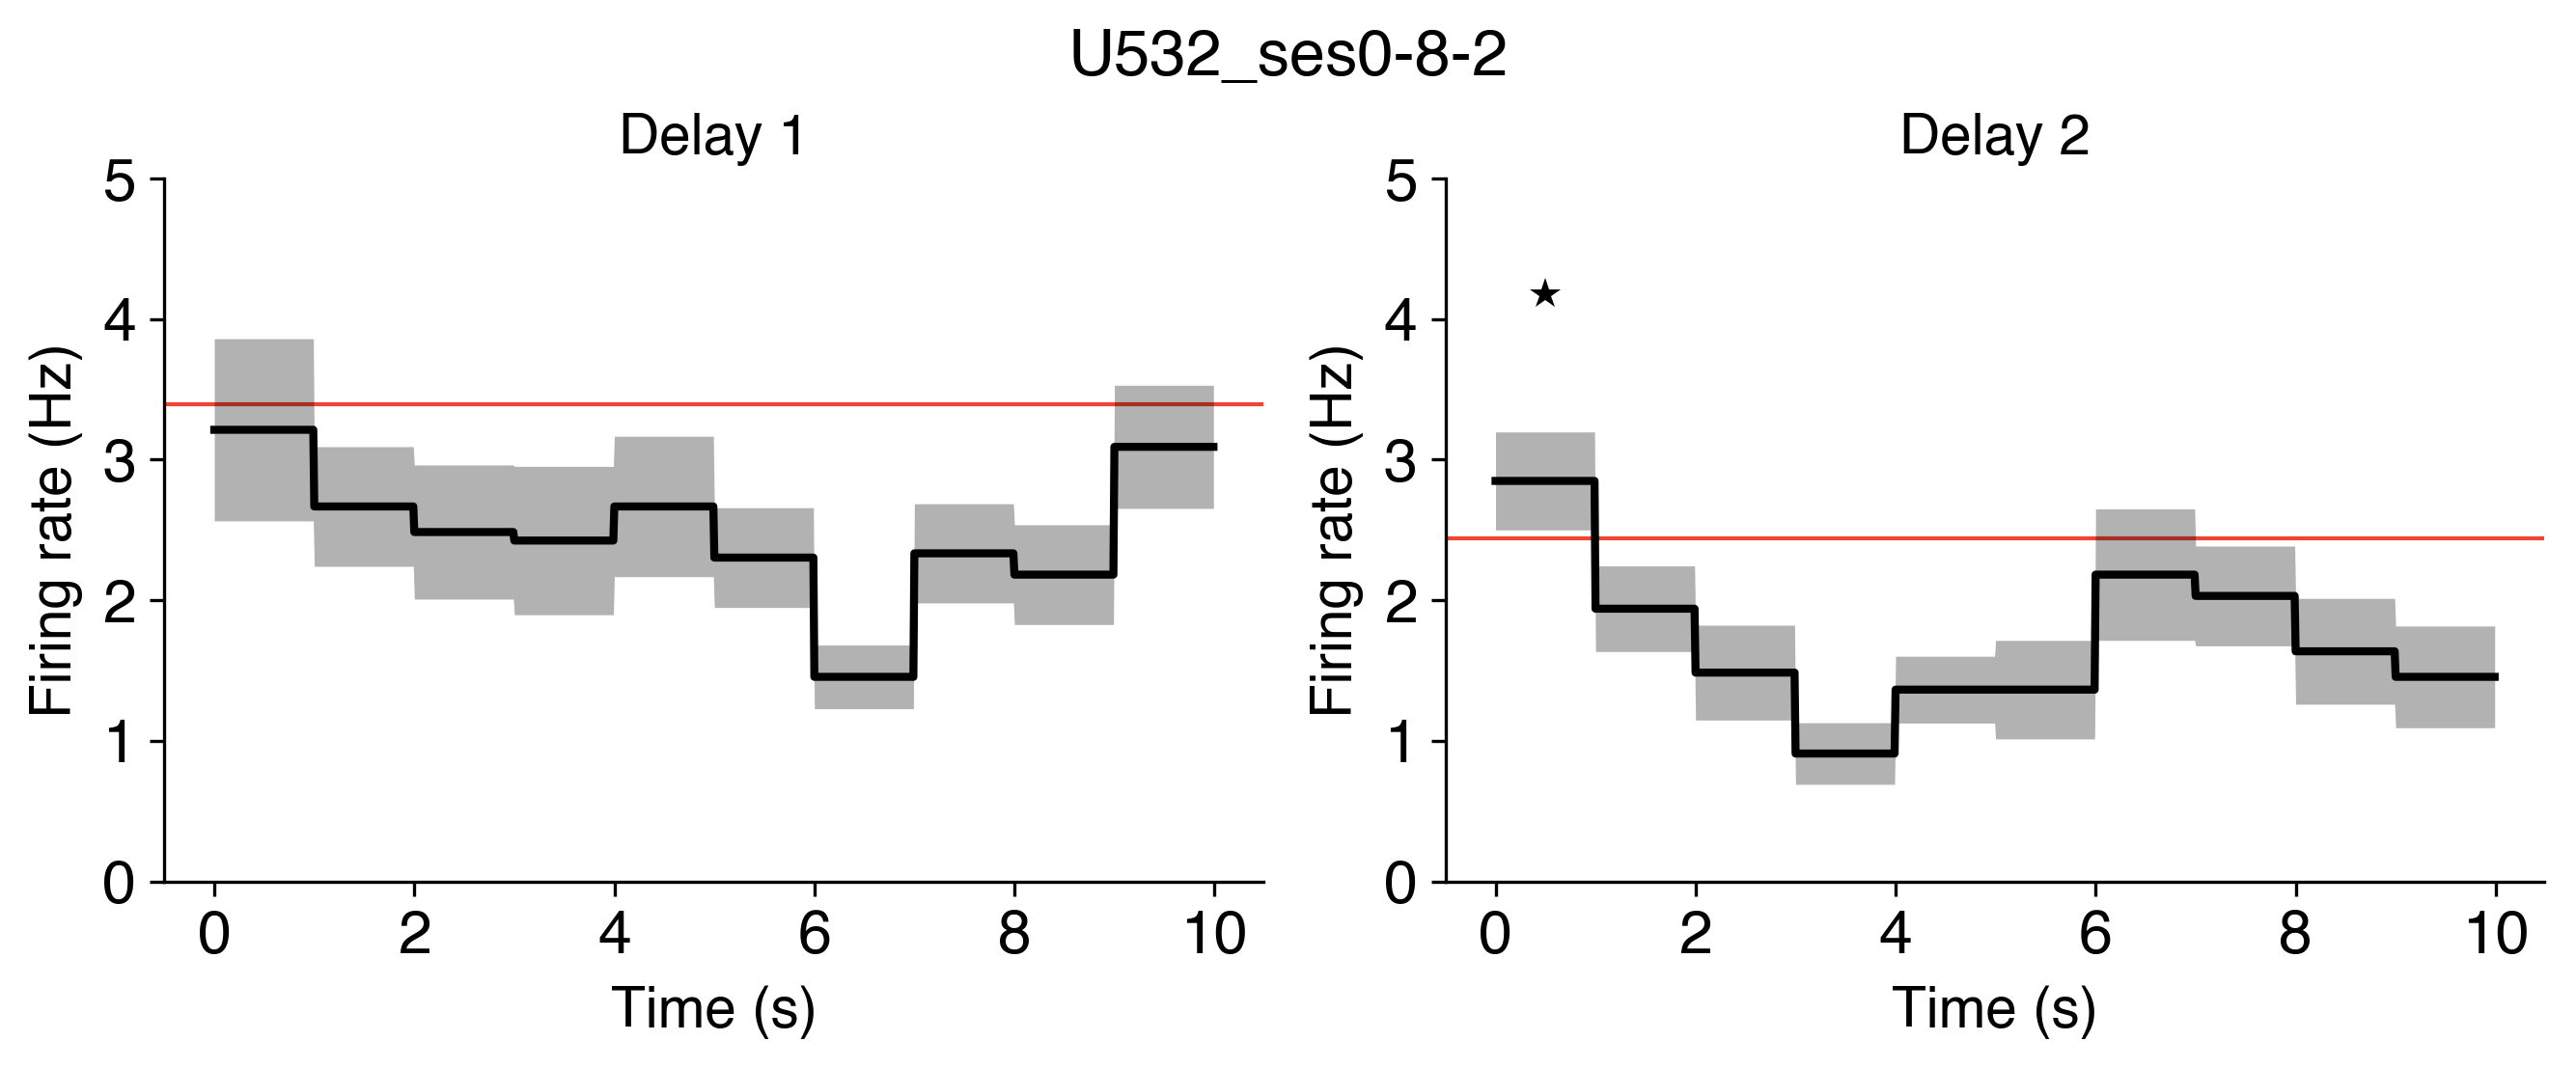

In [89]:
neuron = '8-2'
game_states = ['Delay1', 'Delay2']
bin_sec = True

fig, ax = plt.subplots(1, 2, figsize=(9, 3.5), dpi=300)
ax = np.ravel(ax)

mean_frs = od([])
sem_frs = od([])
cutoff_fr = od([])
time_field = od([])
for game_state in game_states:
    spike_mat = event_spikes.get_spike_mat(neuron, game_state)
    
    # Count spikes over 1s time bins.
    if bin_sec:
        spike_mat = pd.DataFrame(data=spike_mat.values[:, ::2] + spike_mat.values[:, 1::2], 
                                 index=spike_mat.index, columns=np.arange(10))
        spike_mat.columns.name = 'time_bin'
        
    mean_frs[game_state] = get_mean_frs(spike_mat)
    sem_frs[game_state] = get_sem_frs(spike_mat) 
    cutoff_fr[game_state], _, time_field[game_state] = bootstrap_time_fields(spike_mat)
    
    # Convert mean spike counts to firing rate in Hz.
    if not bin_sec:
        mean_frs[game_state] *= 2
        sem_frs[game_state] *= 2
        cutoff_fr[game_state] *= 2
    
    print('{} sparsity = {:.3f}'.format(game_state, get_sparsity(spike_mat)))

# Plot mean firing rates.
_min = np.max((0, np.min((np.min(mean_frs[game_states[0]] - sem_frs[game_states[0]]),
                          np.min(mean_frs[game_states[1]] - sem_frs[game_states[1]])))))
_max = np.max((np.max(mean_frs[game_states[0]] + sem_frs[game_states[0]]),
               np.max(mean_frs[game_states[1]] + sem_frs[game_states[1]])))
for iax, game_state in enumerate(game_states):
    ymin = np.floor(_min)
    ymax = np.ceil(_max + (0.2 * (_max - _min)))
    ystar = _max + (0.1 * (_max - _min))
#     time_field_vec = np.nan * np.zeros(mean_frs[game_state].size)
#     time_field_vec[time_field[game_state]] = ystar
#     xcoords = np.arange(mean_frs[game_state].size)# + 0.5
    datapoints = int(mean_frs[game_state].size * 1e2)
    _xax = np.arange(datapoints)
    _means = np.repeat(mean_frs[game_state], 1e2)
    _sems =np.repeat(sem_frs[game_state], 1e2)
    _time_field = np.zeros(datapoints) * np.nan
    for time_field_idx in time_field[game_state]:
        _time_field[int((time_field_idx*1e2) + (1e2/2))] = ystar
        
    ax[iax].axhline(cutoff_fr[game_state], color=colors[1], lw=1, zorder=0)
    ax[iax].fill_between(_xax, _means + _sems, _means - _sems,
                         color=colors[-1], lw=0, alpha=0.3, zorder=1)
    ax[iax].plot(_xax, _means, 
                 color=colors[-1], lw=2, zorder=2)
    ax[iax].plot(_xax, _time_field, 
                 color=colors[-1], lw=0, alpha=1, marker='*', ms=8, mew=0, zorder=3)
    ax[iax].set_xticks(np.linspace(0, datapoints, 6))
    ax[iax].set_xticklabels(np.linspace(0, 10, 6, dtype=np.int))
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=5)
    ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['label'])

fig.suptitle('{}-{}'.format(event_spikes.subj_sess, neuron), fontsize=font['fig'], y=1.04)
fig.tight_layout()

In [845]:
keep_cols = ['subj_sess_unit', 'gameState', 'testvar', 'reduced', 'full', 'llf_full', 'lr', 'z_lr', 'df', 'emp_pval', 'sig05', 'sig025', 'sig0125', 'sig005']
ols_pairs.query("subj_sess_unit=='U527_ses0-45-1'")[keep_cols]

subj_sess_unit  gameState       testvar        reduced        full  \
2464  U527_ses0-45-1     Delay1          time           icpt        time   
2465  U527_ses0-45-1     Delay2          time           icpt        time   
2466  U527_ses0-45-1   Encoding          time          place  time_place   
2467  U527_ses0-45-1   Encoding         place           time  time_place   
2468  U527_ses0-45-1   Encoding          time   full_subtime        full   
2469  U527_ses0-45-1   Encoding         place  full_subplace        full   
2470  U527_ses0-45-1   Encoding    head_direc     full_subhd        full   
2471  U527_ses0-45-1   Encoding  base_in_view    full_subbiv        full   
2472  U527_ses0-45-1   Encoding  gold_in_view    full_subgiv        full   
2473  U527_ses0-45-1  Retrieval          time          place  time_place   
2474  U527_ses0-45-1  Retrieval         place           time  time_place   
2475  U527_ses0-45-1  Retrieval          time   full_subtime        full   
2476  U527_ses0-45-1  Retrieval         place  full_subplace        full   
2477  U527_ses0-45-1  Retrieval    head_direc     full_subhd        full   
2478  U527_ses0-45-1  Retrieval  base_in_view    full_subbiv        full   
2479  U527_ses0-45-1  Retrieval  gold_in_view    full_subgiv        full   

         llf_full         lr       z_lr  df  emp_pval  sig05  sig025  sig0125  \
2464  -740.289654  17.980215   1.668991   9  0.073926  False   False    False   
2465  -767.275318  26.480349   3.298832   9  0.007992   True    True     True   
2466 -4163.570540  19.953810   0.688876   9  0.241758  False   False    False   
2467 -4163.570540  36.630222   2.510723  11  0.014985   True    True    False   
2468 -4153.194972  21.326524   1.005113   9  0.159840  False   False    False   
2469 -4153.194972  21.142747   0.516783  11  0.287712  False   False    False   
2470 -4153.194972   3.285012  -0.308777   3  0.519481  False   False    False   
2471 -4153.194972   0.000059  -0.678008   1  0.995005  False   False    False   
2472 -4153.194972   6.603836   2.526574   1  0.037962   True   False    False   
2473 -4120.711764  17.444561   0.343774   9  0.301698  False   False    False   
2474 -4120.711764  19.225827   0.002996  11  0.450549  False   False    False   
2475 -4098.298538  17.982268   0.514456   9  0.270729  False   False    False   
2476 -4098.298538  12.546422  -0.777580  11  0.769231  False   False    False   
2477 -4098.298538   8.144648   0.685984   3  0.193806  False   False    False   
2478 -4098.298538   1.426054   0.069194   1  0.303696  False   False    False   
2479 -4098.298538  31.559336  14.513444   1  0.000999   True    True     True   

      sig005  
2464   False  
2465   False  
2466   False  
2467   False  
2468   False  
2469   False  
2470   False  
2471   False  
2472   False  
2473   False  
2474   False  
2475   False  
2476   False  
2477   False  
2478   False  
2479    True

In [844]:
ols_pairs.query("(gameState=='Retrieval') & (testvar=='gold_in_view') & (sig05==True)").sort_values('z_lr', ascending=False)[keep_cols]

subj_sess_unit  gameState       testvar      reduced  full     llf_full  \
2479  U527_ses0-45-1  Retrieval  gold_in_view  full_subgiv  full -4098.298538   
4127  U530_ses1-73-2  Retrieval  gold_in_view  full_subgiv  full -3229.603325   
3775  U530_ses1-15-1  Retrieval  gold_in_view  full_subgiv  full -6126.249958   
1951  U526_ses0-27-1  Retrieval  gold_in_view  full_subgiv  full -5985.160443   
4031  U530_ses1-69-1  Retrieval  gold_in_view  full_subgiv  full -4695.270041   
2559  U527_ses0-58-2  Retrieval  gold_in_view  full_subgiv  full -3409.015141   
2527  U527_ses0-57-1  Retrieval  gold_in_view  full_subgiv  full -5914.737655   
2655   U527_ses0-9-1  Retrieval  gold_in_view  full_subgiv  full -6167.491258   
4175  U530_ses1-76-3  Retrieval  gold_in_view  full_subgiv  full -4378.187883   
2271  U527_ses0-17-1  Retrieval  gold_in_view  full_subgiv  full -4877.430477   
2095  U526_ses0-44-1  Retrieval  gold_in_view  full_subgiv  full -2471.222515   
2287  U527_ses0-17-2  Retrieval  gold_in_view  full_subgiv  full -3933.394945   
3823  U530_ses1-16-3  Retrieval  gold_in_view  full_subgiv  full -3421.417628   
847    U518_ses1-4-1  Retrieval  gold_in_view  full_subgiv  full -4599.530195   
3535  U530_ses0-73-2  Retrieval  gold_in_view  full_subgiv  full -2399.465071   
1455  U521_ses0-21-2  Retrieval  gold_in_view  full_subgiv  full -3013.446468   
2191  U527_ses0-12-1  Retrieval  gold_in_view  full_subgiv  full -1992.297885   
303   U518_ses0-39-1  Retrieval  gold_in_view  full_subgiv  full -4423.143216   
2831   U530_ses0-3-1  Retrieval  gold_in_view  full_subgiv  full -3502.828222   
1695  U521_ses0-69-1  Retrieval  gold_in_view  full_subgiv  full -4311.684447   
2975  U530_ses0-43-2  Retrieval  gold_in_view  full_subgiv  full -4028.708551   
4559   U532_ses0-2-2  Retrieval  gold_in_view  full_subgiv  full -1389.333861   
2495  U527_ses0-45-2  Retrieval  gold_in_view  full_subgiv  full -2553.978664   
4975  U532_ses0-45-3  Retrieval  gold_in_view  full_subgiv  full -3385.167496   
1807  U526_ses0-14-2  Retrieval  gold_in_view  full_subgiv  full -2163.892550   
191   U518_ses0-32-1  Retrieval  gold_in_view  full_subgiv  full -3059.971478   
4207  U530_ses1-77-1  Retrieval  gold_in_view  full_subgiv  full -6229.999118   
3087  U530_ses0-46-3  Retrieval  gold_in_view  full_subgiv  full -4131.847698   
4239  U530_ses1-79-2  Retrieval  gold_in_view  full_subgiv  full -5464.982484   
495   U518_ses0-73-1  Retrieval  gold_in_view  full_subgiv  full -4516.723722   
4415  U532_ses0-14-2  Retrieval  gold_in_view  full_subgiv  full -1041.358425   
2671   U527_ses0-9-2  Retrieval  gold_in_view  full_subgiv  full -3512.136081   
3423   U530_ses0-7-4  Retrieval  gold_in_view  full_subgiv  full -4080.246149   
47    U518_ses0-13-2  Retrieval  gold_in_view  full_subgiv  full -3067.400089   

             lr       z_lr  df  emp_pval  sig05  sig025  sig0125  sig005  
2479  31.559336  14.513444   1  0.000999   True    True     True    True  
4127  42.085491  12.501055   1  0.000999   True    True     True    True  
3775  28.278637  10.598141   1  0.000999   True    True     True    True  
1951  24.953899   8.663671   1  0.001998   True    True     True    True  
4031  23.900540   8.510099   1  0.000999   True    True     True    True  
2559  19.748990   6.050954   1  0.003996   True    True     True    True  
2527  16.226382   5.413536   1  0.001998   True    True     True    True  
2655  13.206343   5.193612   1  0.005994   True    True     True   False  
4175   9.272340   4.863170   1  0.004995   True    True     True    True  
2271  14.175341   4.857831   1  0.006993   True    True     True   False  
2095   7.897734   4.218633   1  0.009990   True    True     True   False  
2287  11.165990   3.991459   1  0.014985   True    True    False   False  
3823  10.184971   3.803042   1  0.007992   True    True     True   False  
847    7.246445   3.520694   1  0.013986   True    True    False   False  
3535  12.611828   3.432516   1  0.014985   Tr

In [841]:
0.05/5, 0.05/4, 0.05/3

(0.01, 0.0125, 0.016666666666666666)

Delay1 sparsity = 0.939
Delay2 sparsity = 0.899


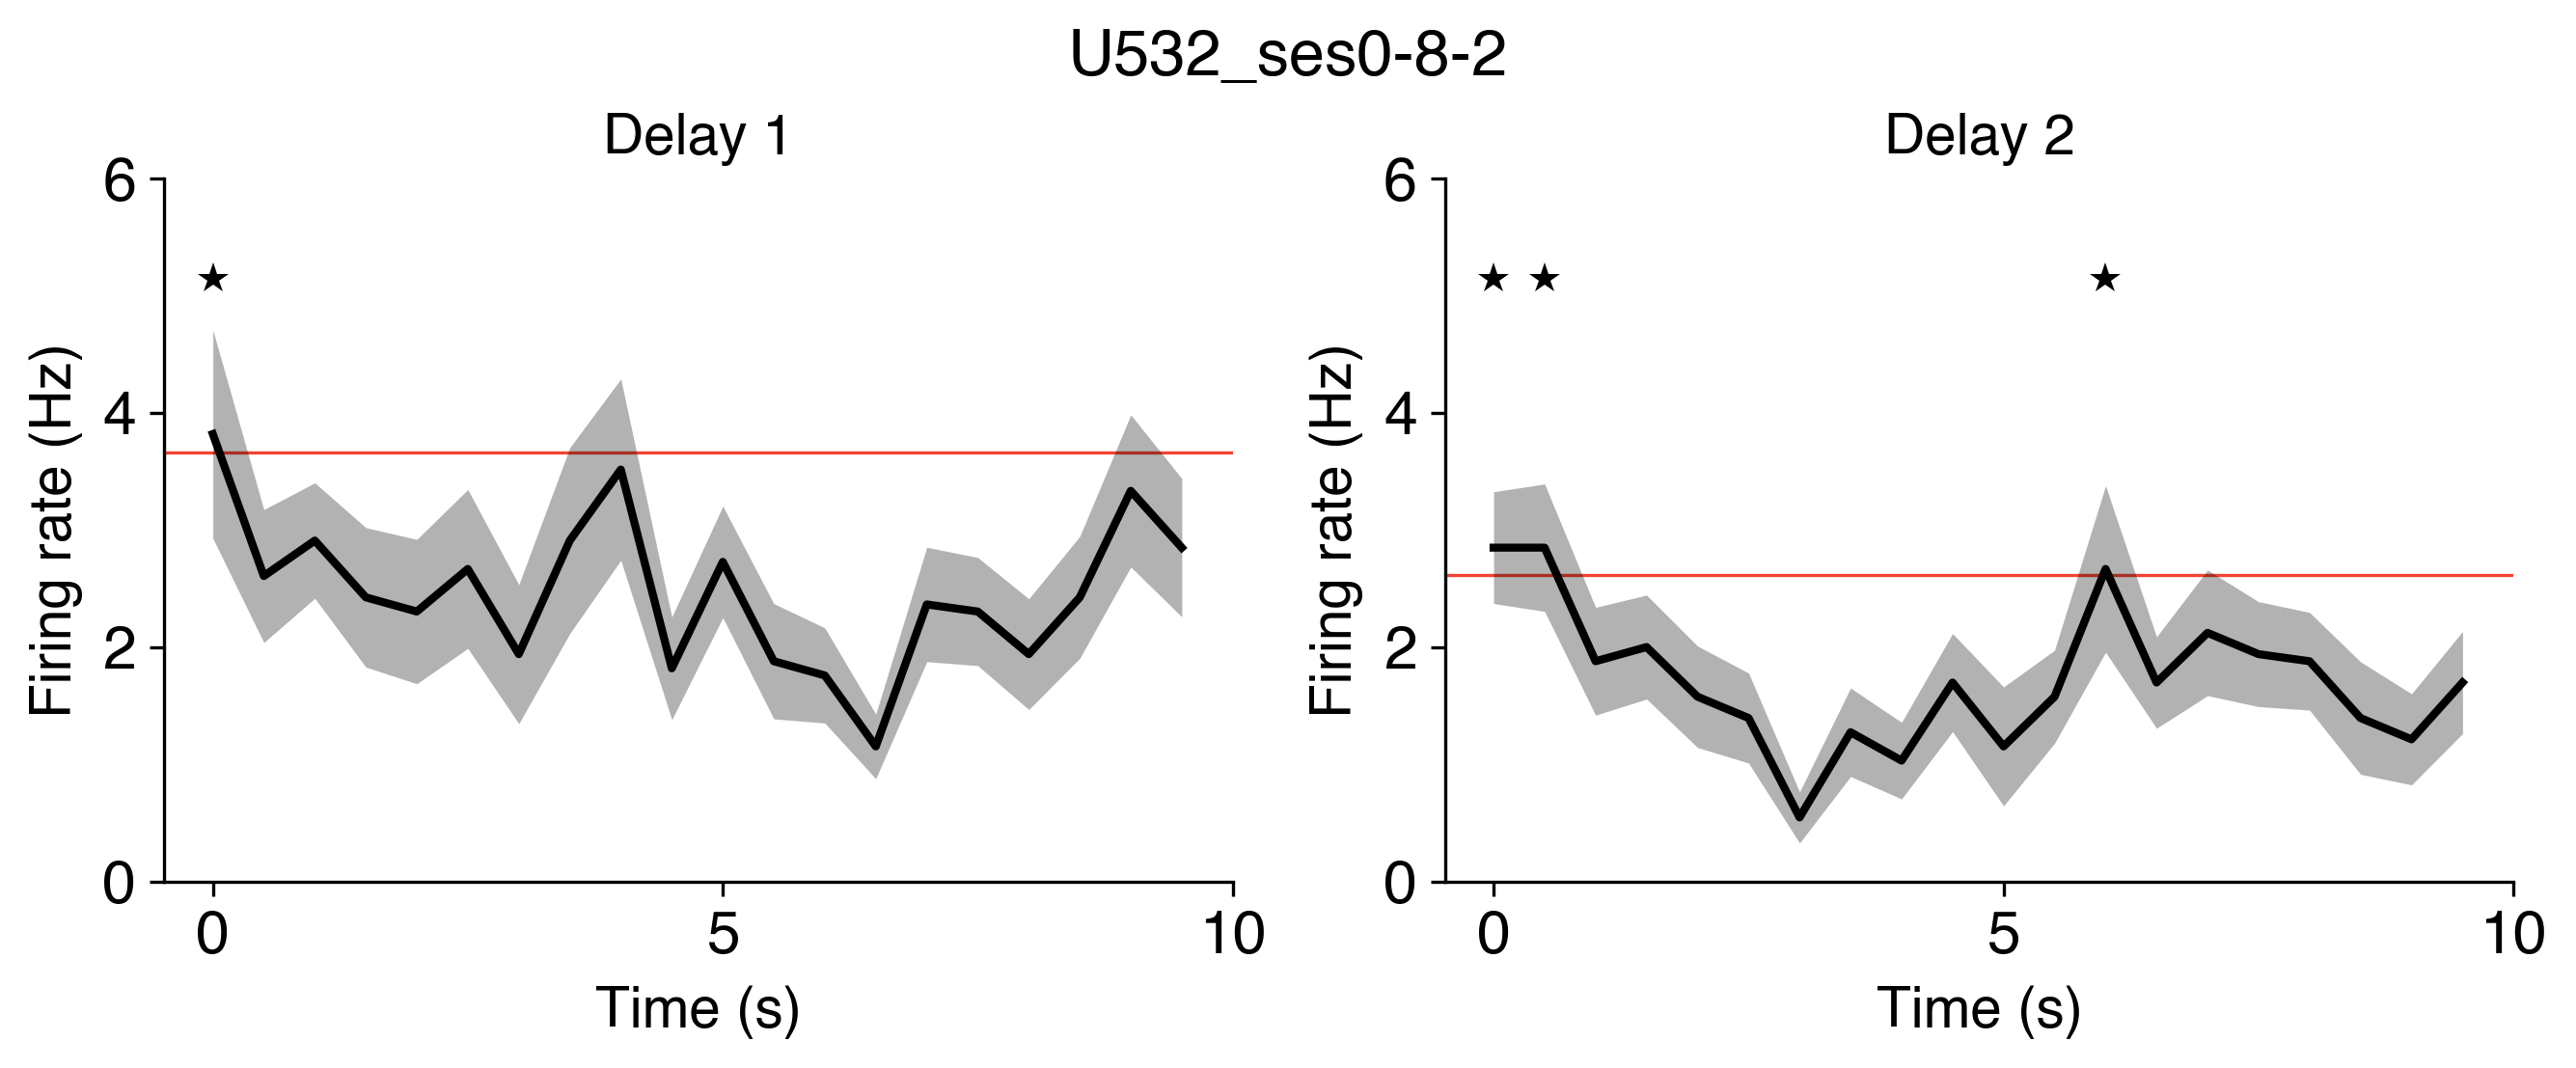

In [7]:
neuron = '8-2'
game_states = ['Delay1', 'Delay2']

fig, ax = plt.subplots(1, 2, figsize=(9, 3.5), dpi=300)
ax = np.ravel(ax)

mean_frs = od([])
sem_frs = od([])
cutoff_fr = od([])
time_field = od([])
for game_state in game_states:
    spike_mat = event_spikes.get_spike_mat(neuron, game_state)
    mean_frs[game_state] = get_mean_frs(spike_mat)
    sem_frs[game_state] = get_sem_frs(spike_mat) 
    cutoff_fr[game_state], _, time_field[game_state] = bootstrap_time_fields(spike_mat)
    print('{} sparsity = {:.3f}'.format(game_state, get_sparsity(spike_mat)))
    
    # Convert mean spike counts to firing rate in Hz.
    mean_frs[game_state] *= 2
    sem_frs[game_state] *= 2
    cutoff_fr[game_state] *= 2

# Plot mean firing rates.
_min = np.max((0, np.min((np.min(mean_frs[game_states[0]] - sem_frs[game_states[0]]),
                          np.min(mean_frs[game_states[1]] - sem_frs[game_states[1]])))))
_max = np.max((np.max(mean_frs[game_states[0]] + sem_frs[game_states[0]]),
               np.max(mean_frs[game_states[1]] + sem_frs[game_states[1]])))
for iax, game_state in enumerate(game_states):
    ymin = np.floor(_min)
    ymax = np.ceil(_max + (0.2 * (_max - _min)))
    ystar = _max + (0.1 * (_max - _min))
    time_field_vec = np.nan * np.zeros(mean_frs[game_state].size)
    time_field_vec[time_field[game_state]] = ystar
    
    ax[iax].axhline(cutoff_fr[game_state], color=colors[1], linewidth=0.8, zorder=0)
    ax[iax].fill_between(np.arange(mean_frs[game_state].size), mean_frs[game_state] + sem_frs[game_state], mean_frs[game_state] - sem_frs[game_state],
                         color=colors[-1], linewidth=0, alpha=0.3, zorder=1)
    ax[iax].plot(mean_frs[game_state], color=colors[-1], linewidth=2, zorder=2)
    ax[iax].plot(time_field_vec, color=colors[-1], marker='*', mew=0, markersize=8, lw=0, alpha=1, zorder=3)
    ax[iax].set_xticks(np.linspace(0, 20, 3))
    ax[iax].set_xticklabels(np.linspace(0, 10, 3, dtype=np.int))
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=5)
    ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['label'])

fig.suptitle('{}-{}'.format(event_spikes.subj_sess, neuron), fontsize=font['fig'], y=1.04)
fig.tight_layout()

In [447]:
def mean_std(vec, axis=None):
    return np.mean(vec, axis=axis), np.std(vec, axis=axis)

game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
_mean, _std = mean_std(event_spikes.event_spikes.query("(gameState=={})".format(game_states))[neuron])
thresh = _mean + (2 * _std)
_mean, _std, thresh

(0.584375, 1.0477318218352267, 2.6798386436704535)

In [444]:
spike_mat = event_spikes.get_spike_mat(neuron, 'Delay1')
_mean, _std = np.mean(spike_mat.values), np.std(spike_mat.values)
thresh = _mean + (2 * _std)
thresh, np.mean(spike_mat, axis=0), np.mean(spike_mat, axis=0) > thresh
sparsity(spike_mat)

0.9338298173080319

In [391]:
reload(time_bin_analysis)

<module 'time_cells.time_bin_analysis' from '/home1/dscho/code/projects/time_cells/time_bin_analysis.py'>

In [387]:
v = np.arange(80, 100)
idx = np.arange(len(v))
print(v, idx)
np.random.shuffle(idx)
print(v[idx], idx)

[80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[91 86 84 92 82 99 83 89 94 93 85 87 88 96 95 80 98 97 81 90] [11  6  4 12  2 19  3  9 14 13  5  7  8 16 15  0 18 17  1 10]


In [392]:
subj_sess = 'U518_ses0'
neuron = '16-2'
game_state = 'Delay1'

warnings.filterwarnings('ignore')
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
res = od([])
res[game_state] = time_bin_analysis.glm_fit(neuron, event_spikes, game_state, n_perm=1000, perm_method='shuffle', optimizer='lbfgs')
comp = time_bin_analysis.get_glm_pairs(res)
warnings.resetwarnings()

<BarContainer object of 31 artists>

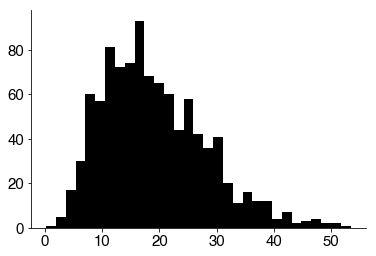

In [369]:
# irls
counts, bin_edges = comp.iloc[0]['null_hist']
plt.bar(np.mean((bin_edges[:-1], bin_edges[1:]), axis=0), counts, 
        width=np.median(np.diff(bin_edges)), color='k')

<BarContainer object of 31 artists>

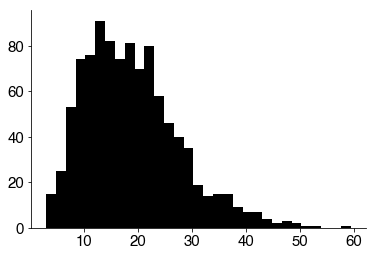

In [375]:
# nm
counts, bin_edges = comp.iloc[0]['null_hist']
plt.bar(np.mean((bin_edges[:-1], bin_edges[1:]), axis=0), counts, 
        width=np.median(np.diff(bin_edges)), color='k')

<BarContainer object of 31 artists>

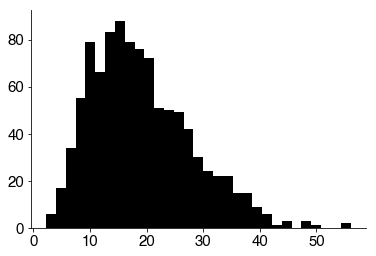

In [393]:
# lbfgs shuffle
counts, bin_edges = comp.iloc[0]['null_hist']
plt.bar(np.mean((bin_edges[:-1], bin_edges[1:]), axis=0), counts, 
        width=np.median(np.diff(bin_edges)), color='k')

<BarContainer object of 31 artists>

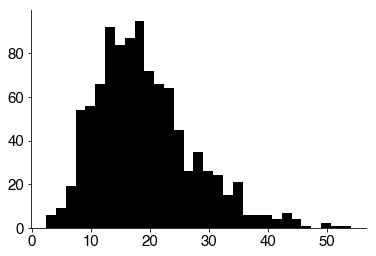

In [359]:
# lbfgs
counts, bin_edges = comp.iloc[0]['null_hist']
plt.bar(np.mean((bin_edges[:-1], bin_edges[1:]), axis=0), counts, 
        width=np.median(np.diff(bin_edges)), color='k')

In [373]:
# irls
comp

subj_sess neuron gameState testvar reduced  full         lr     z_lr    df  \
0  U518_ses0   16-2    Delay1    time    icpt  time  38.392821  2.12518  10.0   

   chi_pval  emp_pval                                          null_hist  \
0  0.000032  0.031968  [[1, 5, 17, 30, 60, 57, 81, 72, 74, 93, 68, 65...   

       icpt    time-1    time-2    time-3    time-4    time-5    time-6  \
0  0.504046 -0.082611  0.481602  0.278891  0.146963 -0.066611 -0.005053   

     time-7    time-8    time-9   time-10   trial-1   trial-2   trial-3  \
0 -0.132208  0.009762 -0.359597  0.232906 -1.496914 -0.485331  0.613281   

    trial-4   trial-5   trial-6   trial-7   trial-8   trial-9  trial-10  \
0  0.517971 -0.937317  0.112506  0.877973  0.335649  0.294827  0.613281   

   trial-11  trial-12  trial-13  trial-14  trial-15  trial-16  trial-17  \
0  0.672121 -0.485332  0.672121  0.061212  0.335649 -0.175177 -0.050013   

   trial-18  trial-19  trial-20  trial-21  trial-22  trial-23  trial-24  \
0 -0.244169 -0.175177 -0.244169  0.207816  0.007145  0.335649  0.294827   

   trial-25  trial-26  trial-27  trial-28  trial-29  trial-30  trial-31  \
0   0.55076 -0.937316  0.007145  0.112506 -0.110638  0.207816  0.112505   

   trial-32  trial-33  trial-34  trial-35  trial-36  
0 -0.686002 -0.050013  0.007145 -0.050013 -0.318277

In [377]:
# nm
comp

subj_sess neuron gameState testvar reduced  full         lr      z_lr  \
0  U518_ses0   16-2    Delay1    time    icpt  time  38.392901  2.210358   

     df  chi_pval  emp_pval  \
0  10.0  0.000032  0.032967   

                                           null_hist      icpt    time-1  \
0  [[15, 25, 53, 74, 76, 91, 82, 74, 81, 70, 80, ...  0.504173 -0.082285   

     time-2    time-3    time-4    time-5    time-6    time-7    time-8  \
0  0.481592  0.278862  0.146985 -0.066654 -0.005119 -0.132249  0.009708   

     time-9   time-10   trial-1   trial-2   trial-3   trial-4  trial-5  \
0 -0.359662  0.232994 -1.496167 -0.485372  0.613302  0.517918 -0.93717   

    trial-6   trial-7   trial-8   trial-9  trial-10  trial-11  trial-12  \
0  0.112456  0.877923  0.335591  0.294792  0.613304  0.672099 -0.485388   

   trial-13  trial-14  trial-15  trial-16  trial-17  trial-18  trial-19  \
0  0.672307  0.061156  0.335592  -0.17522 -0.050056 -0.244227 -0.175229   

   trial-20  trial-21  trial-22  trial-23  trial-24  trial-25  trial-26  \
0 -0.244223  0.207824  0.007089  0.335594  0.294769  0.550741 -0.936927   

   trial-27  trial-28  trial-29  trial-30  trial-31  trial-32  trial-33  \
0  0.007087  0.112449 -0.110695  0.207759   0.11245 -0.685998  -0.05007   

   trial-34  trial-35  trial-36  
0  0.007115 -0.050069 -0.318332

In [394]:
# lbfgs shuffle
comp

subj_sess neuron gameState testvar reduced  full        lr      z_lr    df  \
0  U518_ses0   16-2    Delay1    time    icpt  time  38.39281  2.188651  10.0   

   chi_pval  emp_pval                                          null_hist  \
0  0.000032  0.027972  [[6, 17, 34, 55, 79, 66, 83, 88, 79, 76, 72, 5...   

       icpt    time-1    time-2    time-3    time-4    time-5    time-6  \
0  0.504059 -0.082343  0.481582  0.278858  0.146971 -0.066655 -0.005117   

     time-7    time-8   time-9   time-10   trial-1   trial-2   trial-3  \
0 -0.132251  0.009709 -0.35966  0.232965 -1.496176 -0.485373  0.613294   

    trial-4   trial-5   trial-6  trial-7  trial-8   trial-9  trial-10  \
0  0.517916 -0.937174  0.112454  0.87792  0.33559  0.294789  0.613295   

   trial-11  trial-12  trial-13  trial-14  trial-15  trial-16  trial-17  \
0  0.672094 -0.485389  0.672284  0.061155   0.33559 -0.175221 -0.050057   

   trial-18  trial-19  trial-20  trial-21  trial-22  trial-23  trial-24  \
0 -0.244228  -0.17523 -0.244224  0.207819  0.007088  0.335593  0.294768   

   trial-25  trial-26  trial-27  trial-28  trial-29  trial-30  trial-31  \
0  0.550736 -0.936936  0.007086  0.112448 -0.110696  0.207758  0.112448   

   trial-32  trial-33  trial-34  trial-35  trial-36  
0    -0.686 -0.050071  0.007112  -0.05007 -0.318333

In [356]:
# lbfgs
comp

subj_sess neuron gameState testvar reduced  full        lr      z_lr    df  \
0  U518_ses0   16-2    Delay1    time    icpt  time  38.39281  2.153869  10.0   

   chi_pval  emp_pval                                          null_hist  \
0  0.000032  0.036963  [[10, 38, 67, 79, 108, 103, 105, 96, 80, 66, 5...   

       icpt    time-1    time-2    time-3    time-4    time-5    time-6  \
0  0.504059 -0.082343  0.481582  0.278858  0.146971 -0.066655 -0.005117   

     time-7    time-8   time-9   time-10   trial-1   trial-2   trial-3  \
0 -0.132251  0.009709 -0.35966  0.232965 -1.496176 -0.485373  0.613294   

    trial-4   trial-5   trial-6  trial-7  trial-8   trial-9  trial-10  \
0  0.517916 -0.937174  0.112454  0.87792  0.33559  0.294789  0.613295   

   trial-11  trial-12  trial-13  trial-14  trial-15  trial-16  trial-17  \
0  0.672094 -0.485389  0.672284  0.061155   0.33559 -0.175221 -0.050057   

   trial-18  trial-19  trial-20  trial-21  trial-22  trial-23  trial-24  \
0 -0.244228  -0.17523 -0.244224  0.207819  0.007088  0.335593  0.294768   

   trial-25  trial-26  trial-27  trial-28  trial-29  trial-30  trial-31  \
0  0.550736 -0.936936  0.007086  0.112448 -0.110696  0.207758  0.112448   

   trial-32  trial-33  trial-34  trial-35  trial-36  
0    -0.686 -0.050071  0.007112  -0.05007 -0.318333

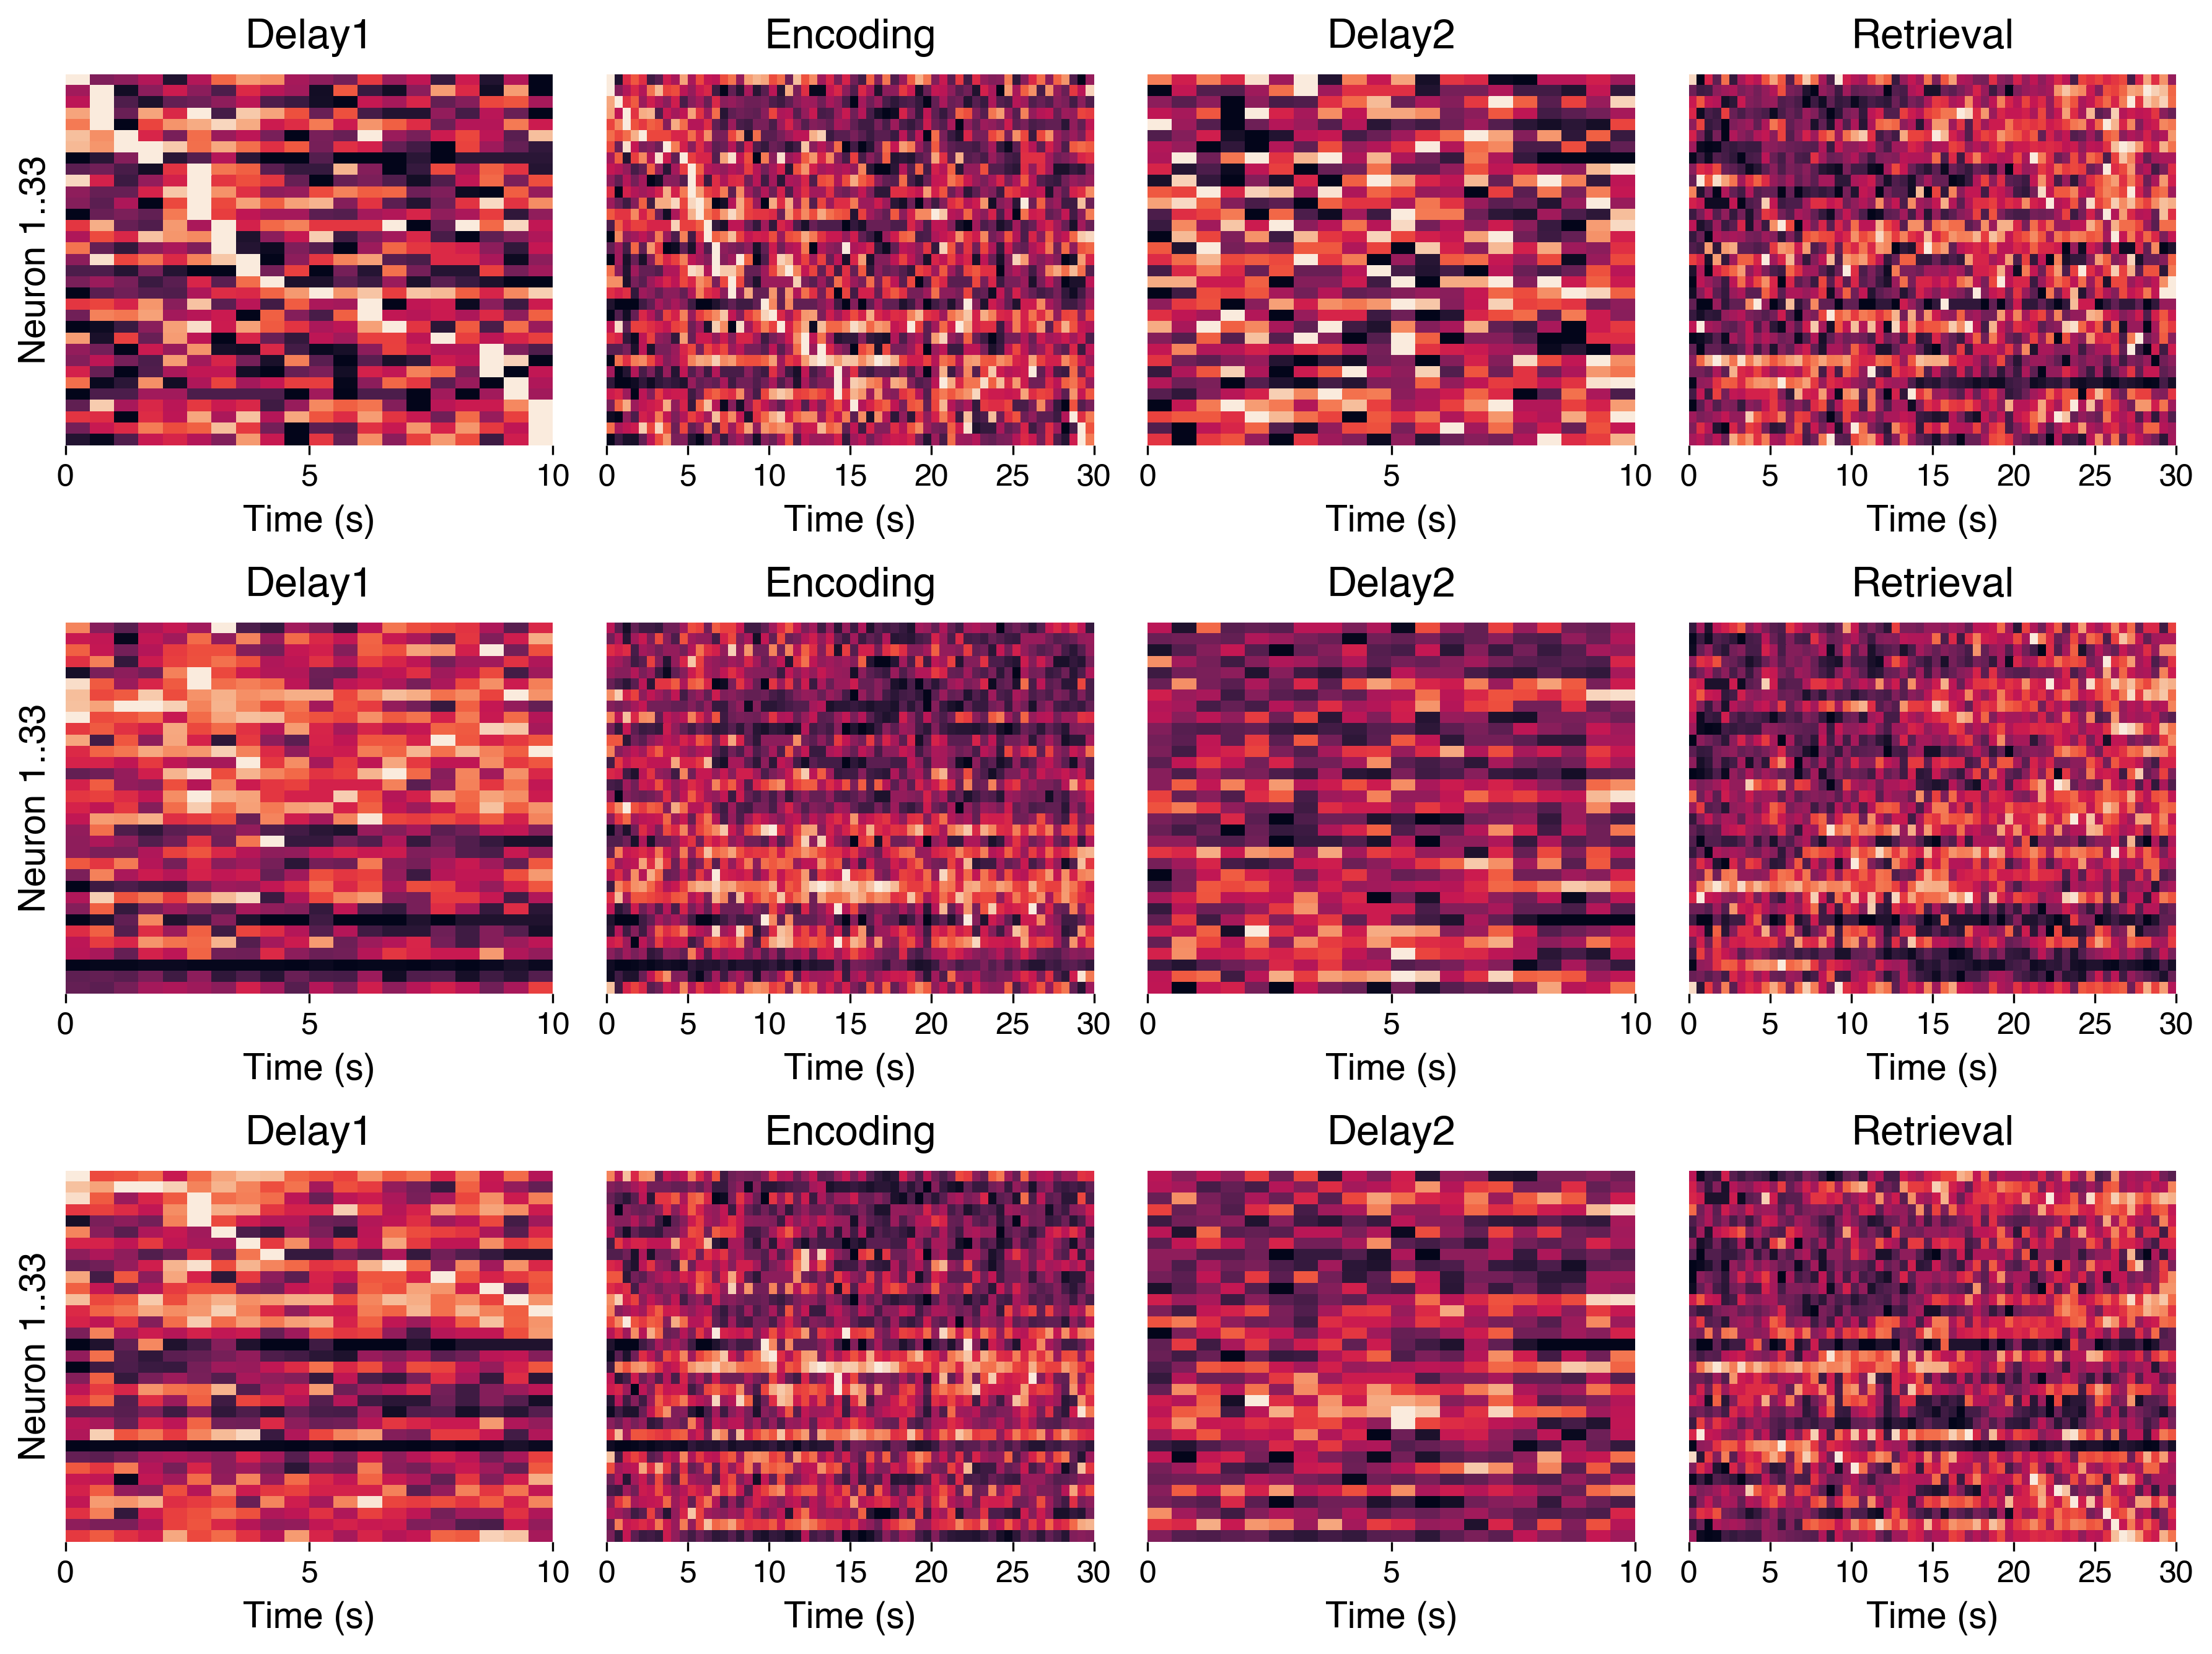

In [1126]:
# Plot mean firing rates over time for all neurons in the session.
fig, ax = plt.subplots(3, 4, figsize=(12, 9), dpi=300)
ax = np.ravel(ax)

game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
next_i = 0

# -------------------------------------------------
# Sort by peak firing time within each trial phase,
# and scale within each trial phase.
xsort = {}
for _i, game_state in enumerate(game_states):
    dat = (event_spikes.query("(gameState=='{}')".format(game_state))
           .groupby('time_bin')
           .agg({col: np.mean for col in neurons}).to_numpy())
    dat = dat.T # neuron x time
    dat = minmax_scale(dat, axis=1)
    
    # Sort neurons by their peak firing time.
    if game_state == 'Delay1':
        xsort['delay'] = np.argsort(np.argmax(dat, axis=1))
    elif game_state == 'Encoding':
        xsort['nav'] = np.argsort(np.argmax(dat, axis=1))
    if game_state in ['Delay1', 'Delay2']:
        dat = dat[xsort['delay'], :]
    elif game_state in ['Encoding', 'Retrieval']:
        dat = dat[xsort['nav'], :]
    
    # Plot the data.
    iax = _i + next_i
    ax[iax] = sns.heatmap(dat, vmin=0, vmax=1, cbar=False, ax=ax[iax])
    ax[iax].set_xticks(np.arange(0, dat.shape[1]+1, 10))
    ax[iax].set_xticklabels(np.arange(0, (dat.shape[1]+1)/2, 5, dtype=np.int),
                            fontsize=font['tick'], rotation=0)
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
    ax[iax].set_yticks([])
    if _i == 0:
        ax[iax].set_ylabel('Neuron 1..{}'.format(dat.shape[0]), 
                           fontsize=font['label'], labelpad=5)
    ax[iax].set_title(game_state, pad=10, fontsize=font['fig'])

next_i = iax + 1

# -------------------------------------------------
# Sort by peak trial phase firing,
# and scale across all trial phases.
dat = (event_spikes.query("(gameState=={})".format(game_states))
       .groupby(['gameState', 'time_bin'])
       .agg({col: np.mean for col in neurons}).to_numpy())
dat = dat.T # neuron x time
dat = minmax_scale(dat, axis=1)

# Split the data into separate game_states.
dat = np.split(dat, [20, 80, 100], axis=1)

# Sort neurons by their peak firing time.
xsort = np.argsort(np.argmax([np.mean(x, axis=1) for x in dat], axis=0))
dat = [x[xsort, :] for x in dat]

# Plot the data.
for _i, game_state in enumerate(game_states):
    iax = _i + next_i
    ax[iax] = sns.heatmap(dat[_i], vmin=0, vmax=1, cbar=False, ax=ax[iax])
    ax[iax].set_xticks(np.arange(0, dat[_i].shape[1]+1, 10))
    ax[iax].set_xticklabels(np.arange(0, (dat[_i].shape[1]+1)/2, 5, dtype=np.int),
                            fontsize=font['tick'], rotation=0)
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
    ax[iax].set_yticks([])
    if _i == 0:
        ax[iax].set_ylabel('Neuron 1..{}'.format(dat[_i].shape[0]), 
                           fontsize=font['label'], labelpad=5)
    ax[iax].set_title(game_state, pad=10, fontsize=font['fig'])

next_i = iax + 1

# -------------------------------------------------
# Plot mean firing rates for all neurons in the session,
# sorted by peak firing time across all trial phases
# and scaled all trial phases.
dat = (event_spikes.query("(gameState=={})".format(game_states))
       .groupby(['gameState', 'time_bin'])
       .agg({col: np.mean for col in neurons}).to_numpy())
dat = dat.T # neuron x time
dat = minmax_scale(dat, axis=1)

# Sort neurons by their peak firing time.
xsort = np.argsort(np.argmax(dat, axis=1))
dat = dat[xsort, :]

# Split the data into separate game_states.
dat = np.split(dat, [20, 80, 100], axis=1)

# Plot the data.
for _i, game_state in enumerate(game_states):
    iax = _i + next_i
    ax[iax] = sns.heatmap(dat[_i], vmin=0, vmax=1, cbar=False, ax=ax[iax])
    ax[iax].set_xticks(np.arange(0, dat[_i].shape[1]+1, 10))
    ax[iax].set_xticklabels(np.arange(0, (dat[_i].shape[1]+1)/2, 5, dtype=np.int),
                           fontsize=font['tick'], rotation=0)
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
    ax[iax].set_yticks([])
    if _i == 0:
        ax[iax].set_ylabel('Neuron 1..{}'.format(dat[_i].shape[0]), 
                           fontsize=font['label'], labelpad=5)
    ax[iax].set_title(game_state, pad=10, fontsize=font['fig'])

fig.tight_layout()

In [607]:
# Compute Jaccard similarity between all pairs of behavioral parameters,
# separately for Encoding and Retrieval.

# Identify behavioral column pairs.
event_spikes = time_bin_analysis.load_event_spikes(sessions[0], verbose=False)
behav_cols = od([('Encoding', [col for col in event_spikes.column_map['behav'] 
                               if ((col!='icpt') & (col[:6]!='trial-') & (col!='dig_performed'))]),
                 ('Retrieval', [col for col in event_spikes.column_map['behav'] 
                                if ((col!='icpt') & (col[:6]!='trial-'))])])
col_pairs = od([])
for game_state in ['Encoding', 'Retrieval']:
    col_pairs[game_state] = [(c1, c2) 
                             for (i1, c1) in enumerate(behav_cols[game_state]) 
                             for (i2, c2) in enumerate(behav_cols[game_state]) 
                             if (i1 < i2)]

# Get Jaccard score between each pair, for each session.
col_names = ['subj_sess', 'gameState', 'col1', 'col2', 'score']
jaccard_sims = []
for subj_sess in sessions:
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
    for game_state in ['Encoding', 'Retrieval']:
        df = event_spikes.event_spikes.query("(gameState=='{}')".format(game_state))[behav_cols[game_state]].fillna(0)
        for c1, c2 in col_pairs[game_state]:
            score = jaccard_score(df[c1], df[c2])
            jaccard_sims.append([subj_sess, game_state, c1, c2, score])
jaccard_sims = pd.DataFrame(jaccard_sims, columns=col_names)

# Calculate mean Jaccard over testing sessions.
mean_jaccard = jaccard_sims.groupby(['gameState', 'col1', 'col2'], sort=False)['score'].mean().reset_index()

# Convert mean_jaccard to a lower triangle matrix that we can plot.
jaccard_mat = od([])
for game_state, _df in mean_jaccard.groupby('gameState'):
    jaccard_mat[game_state] = _df.pivot('col1', 'col2', 'score').reindex(behav_cols[game_state])
    if behav_cols[game_state][0] not in jaccard_mat[game_state].columns:
        jaccard_mat[game_state][behav_cols[game_state][0]] = np.nan
    jaccard_mat[game_state] = jaccard_mat[game_state][behav_cols[game_state]].T

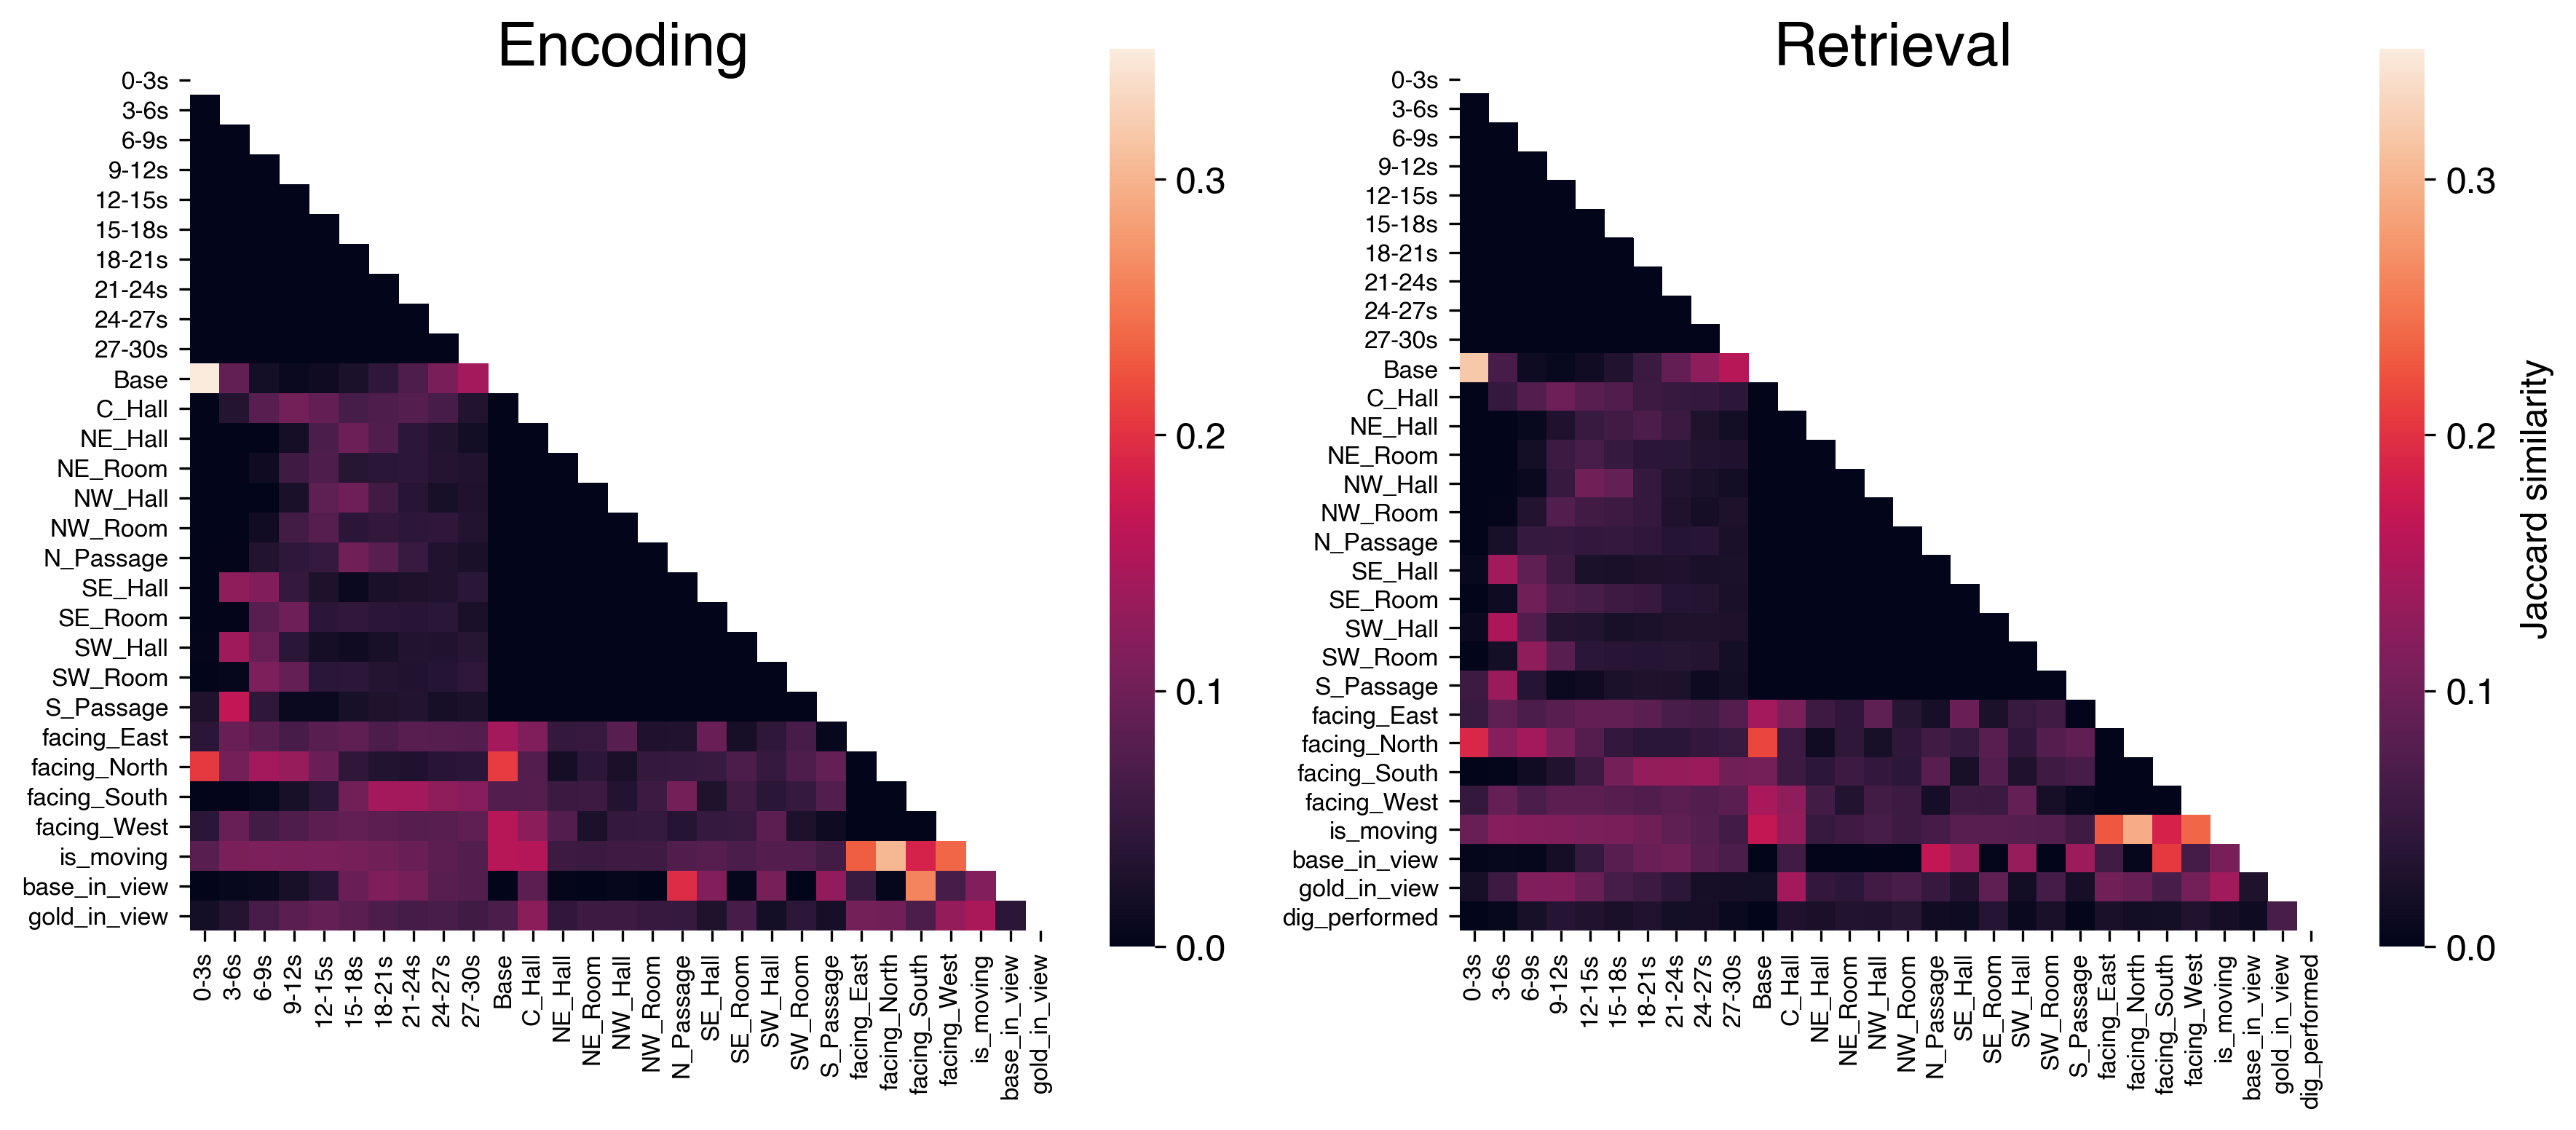

In [828]:
# Plot the cosine similarity between dummy-coded 
# behavioral states during encoding and retrieval.
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

# Replace dataframe column names with nicer label values where needed.
str_map = od({'place-': '', 
              'hd-N': 'facing_North',
              'hd-S': 'facing_South',
              'hd-E': 'facing_East',
              'hd-W': 'facing_West'})
for val in np.arange(10, 0, -1):
    str_map['time-{}'.format(val)] = '{}-{}s'.format((val-1) * 3, val * 3)

# Plot the data.
vmin = 0
vmax = np.max((np.nanmax(jaccard_mat['Encoding']), np.nanmax(jaccard_mat['Retrieval'])))
for iax, game_state in enumerate(['Encoding', 'Retrieval']):
    ax[iax] = sns.heatmap(jaccard_mat[game_state], vmin=vmin, vmax=vmax, square=True, ax=ax[iax])
    col_labels = str_replace(behav_cols[game_state], str_map)
    ax[iax].set_xticks(np.arange(0, len(col_labels), 1) + 0.5)
    ax[iax].set_xticklabels(col_labels, fontsize=font['tick'] - 4, rotation=90)
    ax[iax].set_yticks(np.arange(0, len(col_labels), 1) + 0.5)
    ax[iax].set_yticklabels(col_labels, fontsize=font['tick'] - 4, rotation=0)
    ax[iax].set_xlabel('')
    ax[iax].set_ylabel('')
    ax[iax].set_title(game_state, pad=0, fontsize=font['fig'] + 4)
    
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['label'])
    cbar.set_ticks([0.0, 0.1, 0.2, 0.3])
    cbar.set_ticklabels([0.0, 0.1, 0.2, 0.3])
    if game_state == 'Retrieval':
        cbar.set_label('Jaccard similarity', fontsize=font['label'], labelpad=8)
    else:
        cbar.set_label('', fontsize=font['label'], labelpad=5)
    
fig.tight_layout()
if False:
#     fig.savefig(op.join(proj_dir, 'figs', 'behavioral_param_jaccard_sims-{}_sessions.png'.format(len(sessions))), 
#                 dpi='figure', facecolor='w', edgecolor='none', transparent=False, bbox_inches='tight')
    fig.savefig(op.join(proj_dir, 'figs', 'behavioral_param_jaccard_sims-{}_sessions.pdf'.format(len(sessions))), 
                dpi='figure', facecolor='w', edgecolor='none', transparent=False, bbox_inches='tight')

In [34]:
start_time = time()

# Load all time OLS result files.
ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))
print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

warnings.filterwarnings('ignore')
bad_files = []
ols_pairs = pd.DataFrame([])
for filename in ols_pairs_files:
    try:
        ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
    except:
        bad_files.append(filename)
ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
warnings.resetwarnings()

# # Restrict dataframe rows to delay periods.
# keep_cols = ['subj_sess', 'neuron', 'gameState', 'testvar', 'llf_full', 'lr', 'z_lr', 'emp_pval']
# ols_pairs = ols_pairs.query("(gameState==['Delay1', 'Delay2'])")[keep_cols].reset_index(drop=True)

# Organize categorical columns.
game_states = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
game_state_cat = pd.CategoricalDtype(game_states, ordered=True)
ols_pairs['gameState'] = ols_pairs['gameState'].astype(game_state_cat)

# Add new columns.
roi_map = spike_preproc.roi_mapping()
val_map = od([('hem', []),
              ('roi', []),
              ('roi_gen', []),
              ('spike_mat'        , []),
              ('mean_frs'         , []),
              ('sem_frs'          , []),
              ('fr_mean'          , []),
              ('fr_max'           , []),
              ('fr_max_ind'       , []),
              ('sparsity'         , [])])
for idx, row in ols_pairs.iterrows():
    if 'event_spikes' not in dir():
        event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
    elif event_spikes.subj_sess != row['subj_sess']:
        event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
    hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
    hem = hemroi[0]
    roi = hemroi[1:]
    roi_gen = roi_map.get(roi, np.nan)
    spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
    mean_frs = time_bin_analysis.get_mean_frs(spike_mat) * 2
    sem_frs = time_bin_analysis.get_sem_frs(spike_mat) * 2
    fr_mean = np.mean(mean_frs.values)
    fr_max = np.max(mean_frs.values)
    fr_max_ind = np.argmax(mean_frs.values)
    sparsity = time_bin_analysis.get_sparsity(spike_mat)
    val_map['hem'].append(hem)
    val_map['roi'].append(roi)
    val_map['roi_gen'].append(roi_gen)
    val_map['spike_mat'].append(spike_mat.values.tolist())
    val_map['mean_frs'].append(mean_frs.tolist())
    val_map['sem_frs'].append(sem_frs.tolist())
    val_map['fr_mean'].append(fr_mean)
    val_map['fr_max'].append(fr_max)
    val_map['fr_max_ind'].append(fr_max_ind)
    val_map['sparsity'].append(sparsity)

ols_pairs.insert(0, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
ols_pairs.insert(2, 'subj', ols_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
ols_pairs.insert(4, 'hem', val_map['hem'])
ols_pairs.insert(5, 'roi', val_map['roi'])
ols_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
for col_name in val_map:
    if col_name not in ols_pairs:
        ols_pairs[col_name] = val_map[col_name]

# Test significance.
alpha = 0.05
ols_pairs['sig'] = False
ols_pairs.loc[((ols_pairs['emp_pval']<alpha)), 'sig'] = True
#ols_pairs.loc[((ols_pairs['emp_pval']<alpha) & (ols_pairs['time_field_size']>0)), 'sig'] = True

print('{} bad files'.format(len(bad_files)))
print('ols_pairs:', ols_pairs.shape)

print('Done in {:.1f}s'.format(time() - start_time))

Found OLS outputs for 334 neurons
0 bad files
ols_pairs: (5344, 89)
Done in 60.5s


In [5]:
# Load all time, place OLS result files.
ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*.pkl'))
print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

warnings.filterwarnings('ignore')
bad_files = []
ols_pairs = pd.DataFrame([])
for filename in ols_pairs_files:
    try:
        ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
    except:
        bad_files.append(filename)
ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
warnings.resetwarnings()

# Organize categorical columns.
game_states = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
game_state_cat = pd.CategoricalDtype(game_states, ordered=True)
ols_pairs['gameState'] = ols_pairs['gameState'].astype(game_state_cat)

test_vars = ['time', 'place', 'head_direc', 'gold_in_view', 'base_in_view']
test_var_cat = pd.CategoricalDtype(test_vars, ordered=True)
ols_pairs['testvar'] = ols_pairs['testvar'].astype(test_var_cat)

full_models = ['time', 'time_place', 'full']
full_model_cat = pd.CategoricalDtype(full_models, ordered=True)
ols_pairs['full'] = ols_pairs['full'].astype(full_model_cat)

# Rename and reorder columns.
rename_cols = od()
rename_cols['Intercept'] = 'icpt'
for val in range(2, 11):
    rename_cols['C(time_step)[T.{}]'.format(val)] = 'time-{}'.format(val)
for val in [col for col in ols_pairs.columns if 'maze_region' in col]:
    rename_cols[val] = val.replace('C(maze_region)[T.', 'place-')[:-1]
for val in [col for col in ols_pairs.columns if 'head_direc' in col]:
    rename_cols[val] = val.replace('C(head_direc)[T.', 'hd-')[:-1]
for val in range(2, 37):
    rename_cols['C(trial)[T.{}]'.format(val)] = 'trial-{}'.format(val)
for oldname, newname in rename_cols.items():
    if oldname in ols_pairs.columns:
        ols_pairs.rename(columns={oldname: newname}, inplace=True)
param_cols = (['icpt'] + 
              ['time-{}'.format(val) for val in range(1, 11) if 'time-{}'.format(val) in ols_pairs.columns] + 
              [col for col in ols_pairs.columns if 'place-' in col] +
              [col for col in ols_pairs.columns if 'hd-' in col] +
              ['is_moving', 'base_in_view', 'gold_in_view', 'dig_performed'] +
              [col for col in ols_pairs.columns if 'trial-' in col])
reorder_cols = (['subj_sess', 'neuron',   'gameState', 'testvar', 'reduced',
                 'full',      'llf_full', 'lr',        'z_lr',    'df',
                 'chi_pval',  'emp_pval', 'null_hist'] + param_cols)
ols_pairs = ols_pairs[reorder_cols]

# Add new columns.
ols_pairs.insert(0, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
ols_pairs.insert(11, 'params_full', ols_pairs.apply(lambda x: len([x[col] for col in param_cols if not np.isnan(x[col])]), axis=1))
#ols_pairs.insert(8, 'aic', ols_pairs.apply(lambda x: (2 * x['params_full']) - (2 * x['llf_full']), axis=1))

print('{} bad files'.format(len(bad_files)))
print('ols_pairs:', ols_pairs.shape)

# Test significance.
for col in ['sig05', 'sig025', 'sig0125', 'sig005', 'sig_fdr05']:
    if col in ols_pairs:
        ols_pairs.drop(columns=col, inplace=True)

alpha = 0.05
ols_pairs.insert(17, 'sig05', False)
ols_pairs.loc[(ols_pairs['emp_pval']<alpha), 'sig05'] = True

alpha = 0.025
ols_pairs.insert(18, 'sig025', False)
ols_pairs.loc[(ols_pairs['emp_pval']<alpha), 'sig025'] = True

alpha = 0.0125
ols_pairs.insert(19, 'sig0125', False)
ols_pairs.loc[(ols_pairs['emp_pval']<alpha), 'sig0125'] = True

alpha = 0.005
ols_pairs.insert(20, 'sig005', False)
ols_pairs.loc[(ols_pairs['emp_pval']<alpha), 'sig005'] = True

Found OLS outputs for 668 neurons
0 bad files
ols_pairs: (7682, 78)


In [548]:
# Load all time, place GLM result files.
glm_pairs_files = glob(op.join(proj_dir, 'analysis', 'behav_glms', '*.pkl'))
print('Found GLM outputs for {} neurons'.format(len(glm_pairs_files)))

# glm_pairs = pd.concat([dio.open_pickle(f) for f in glm_pairs_files]).sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
# glm_pairs.insert(0, 'subj_sess_unit', glm_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
bad_files = []
glm_pairs = pd.DataFrame([])
for filename in glm_pairs_files:
    try:
        glm_pairs = pd.concat((glm_pairs, dio.open_pickle(filename)))
    except:
        bad_files.append(filename)
glm_pairs = glm_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)

# Add columns.
def mean_ss(vec):
    """Return the mean sum of squares."""
    n = len(vec)
    ss = np.sum(np.square(vec))
    return ss / n

behav_cols = time_bin_analysis.load_event_spikes('U518_ses0').column_map
glm_pairs.insert(0, 'subj_sess_unit', glm_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
glm_pairs.insert(9, 'ss_time', np.sum(glm_pairs[behav_cols['time']] ** 2, axis=1) / len(behav_cols['time']))
glm_pairs.insert(10, 'ss_place', np.sum(glm_pairs[behav_cols['place']] ** 2, axis=1) / len(behav_cols['place']))

# Organize categorical columns.
game_states = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
game_state_cat = pd.CategoricalDtype(game_states, ordered=True)
glm_pairs['gameState'] = glm_pairs['gameState'].astype(game_state_cat)

test_vars = ['time', 'place', 'head_direc', 'gold_in_view', 'base_in_view']
test_var_cat = pd.CategoricalDtype(test_vars, ordered=True)
glm_pairs['testvar'] = glm_pairs['testvar'].astype(test_var_cat)

full_models = ['time', 'time_place', 'full']
full_model_cat = pd.CategoricalDtype(full_models, ordered=True)
glm_pairs['full'] = glm_pairs['full'].astype(full_model_cat)

print('{} bad files'.format(len(bad_files)))
print('glm_pairs:', glm_pairs.shape)

# Test significance.
for col in ['sig05', 'sig025', 'sig0125', 'sig005', 'sig_fdr05']:
    if col in glm_pairs:
        glm_pairs.drop(columns=col, inplace=True)

alpha = 0.05
glm_pairs.insert(14, 'sig05', False)
glm_pairs.loc[(glm_pairs['emp_pval']<alpha) & (glm_pairs['aic_diff']>0), 'sig05'] = True

alpha = 0.025
glm_pairs.insert(15, 'sig025', False)
glm_pairs.loc[(glm_pairs['emp_pval']<alpha) & (glm_pairs['aic_diff']>0), 'sig025'] = True

alpha = 0.0125
glm_pairs.insert(16, 'sig0125', False)
glm_pairs.loc[(glm_pairs['emp_pval']<alpha) & (glm_pairs['aic_diff']>0), 'sig0125'] = True

alpha = 0.005
glm_pairs.insert(17, 'sig005', False)
glm_pairs.loc[(glm_pairs['emp_pval']<alpha) & (glm_pairs['aic_diff']>0), 'sig005'] = True

Found GLM outputs for 334 neurons
Loading saved EventSpikes file
0 bad files
glm_pairs: (5344, 46)


In [688]:
keep_cols1 = ['subj_sess_unit', 'gameState', 'testvar', 'reduced', 'full', 'lr', 'z_lr', 'emp_pval', 'sig05']
keep_cols2 = ['subj_sess_unit', 'gameState', 'testvar', 'reduced', 'full', 'lr', 'z_aic_diff', 'emp_pval', 'sig05']
df = pd.merge(ols_pairs[keep_cols1], glm_pairs[keep_cols2], on=['subj_sess_unit', 'gameState', 'testvar', 'reduced', 'full'])

# Determine if each neuron is a time cell, place cell, both, or neither.
df['sig_state'] = 0
df.loc[(df['sig05_x']==False) & (df['sig05_y']==True), 'sig_state'] = 2
df.loc[(df['sig05_x']==True) & (df['sig05_y']==False), 'sig_state'] = 3
df.loc[(df['sig05_x']==True) & (df['sig05_y']==True), 'sig_state'] = 1

df.shape, df['subj_sess_unit'].unique().size

((5344, 14), 334)

In [694]:
_cmap = sns.color_palette('tab10', 10)
_cmap = np.array(_cmap)[(7, 4, 1, 9), :]
_cmap[0, :] *= 1.5
_cmap = _cmap.tolist()

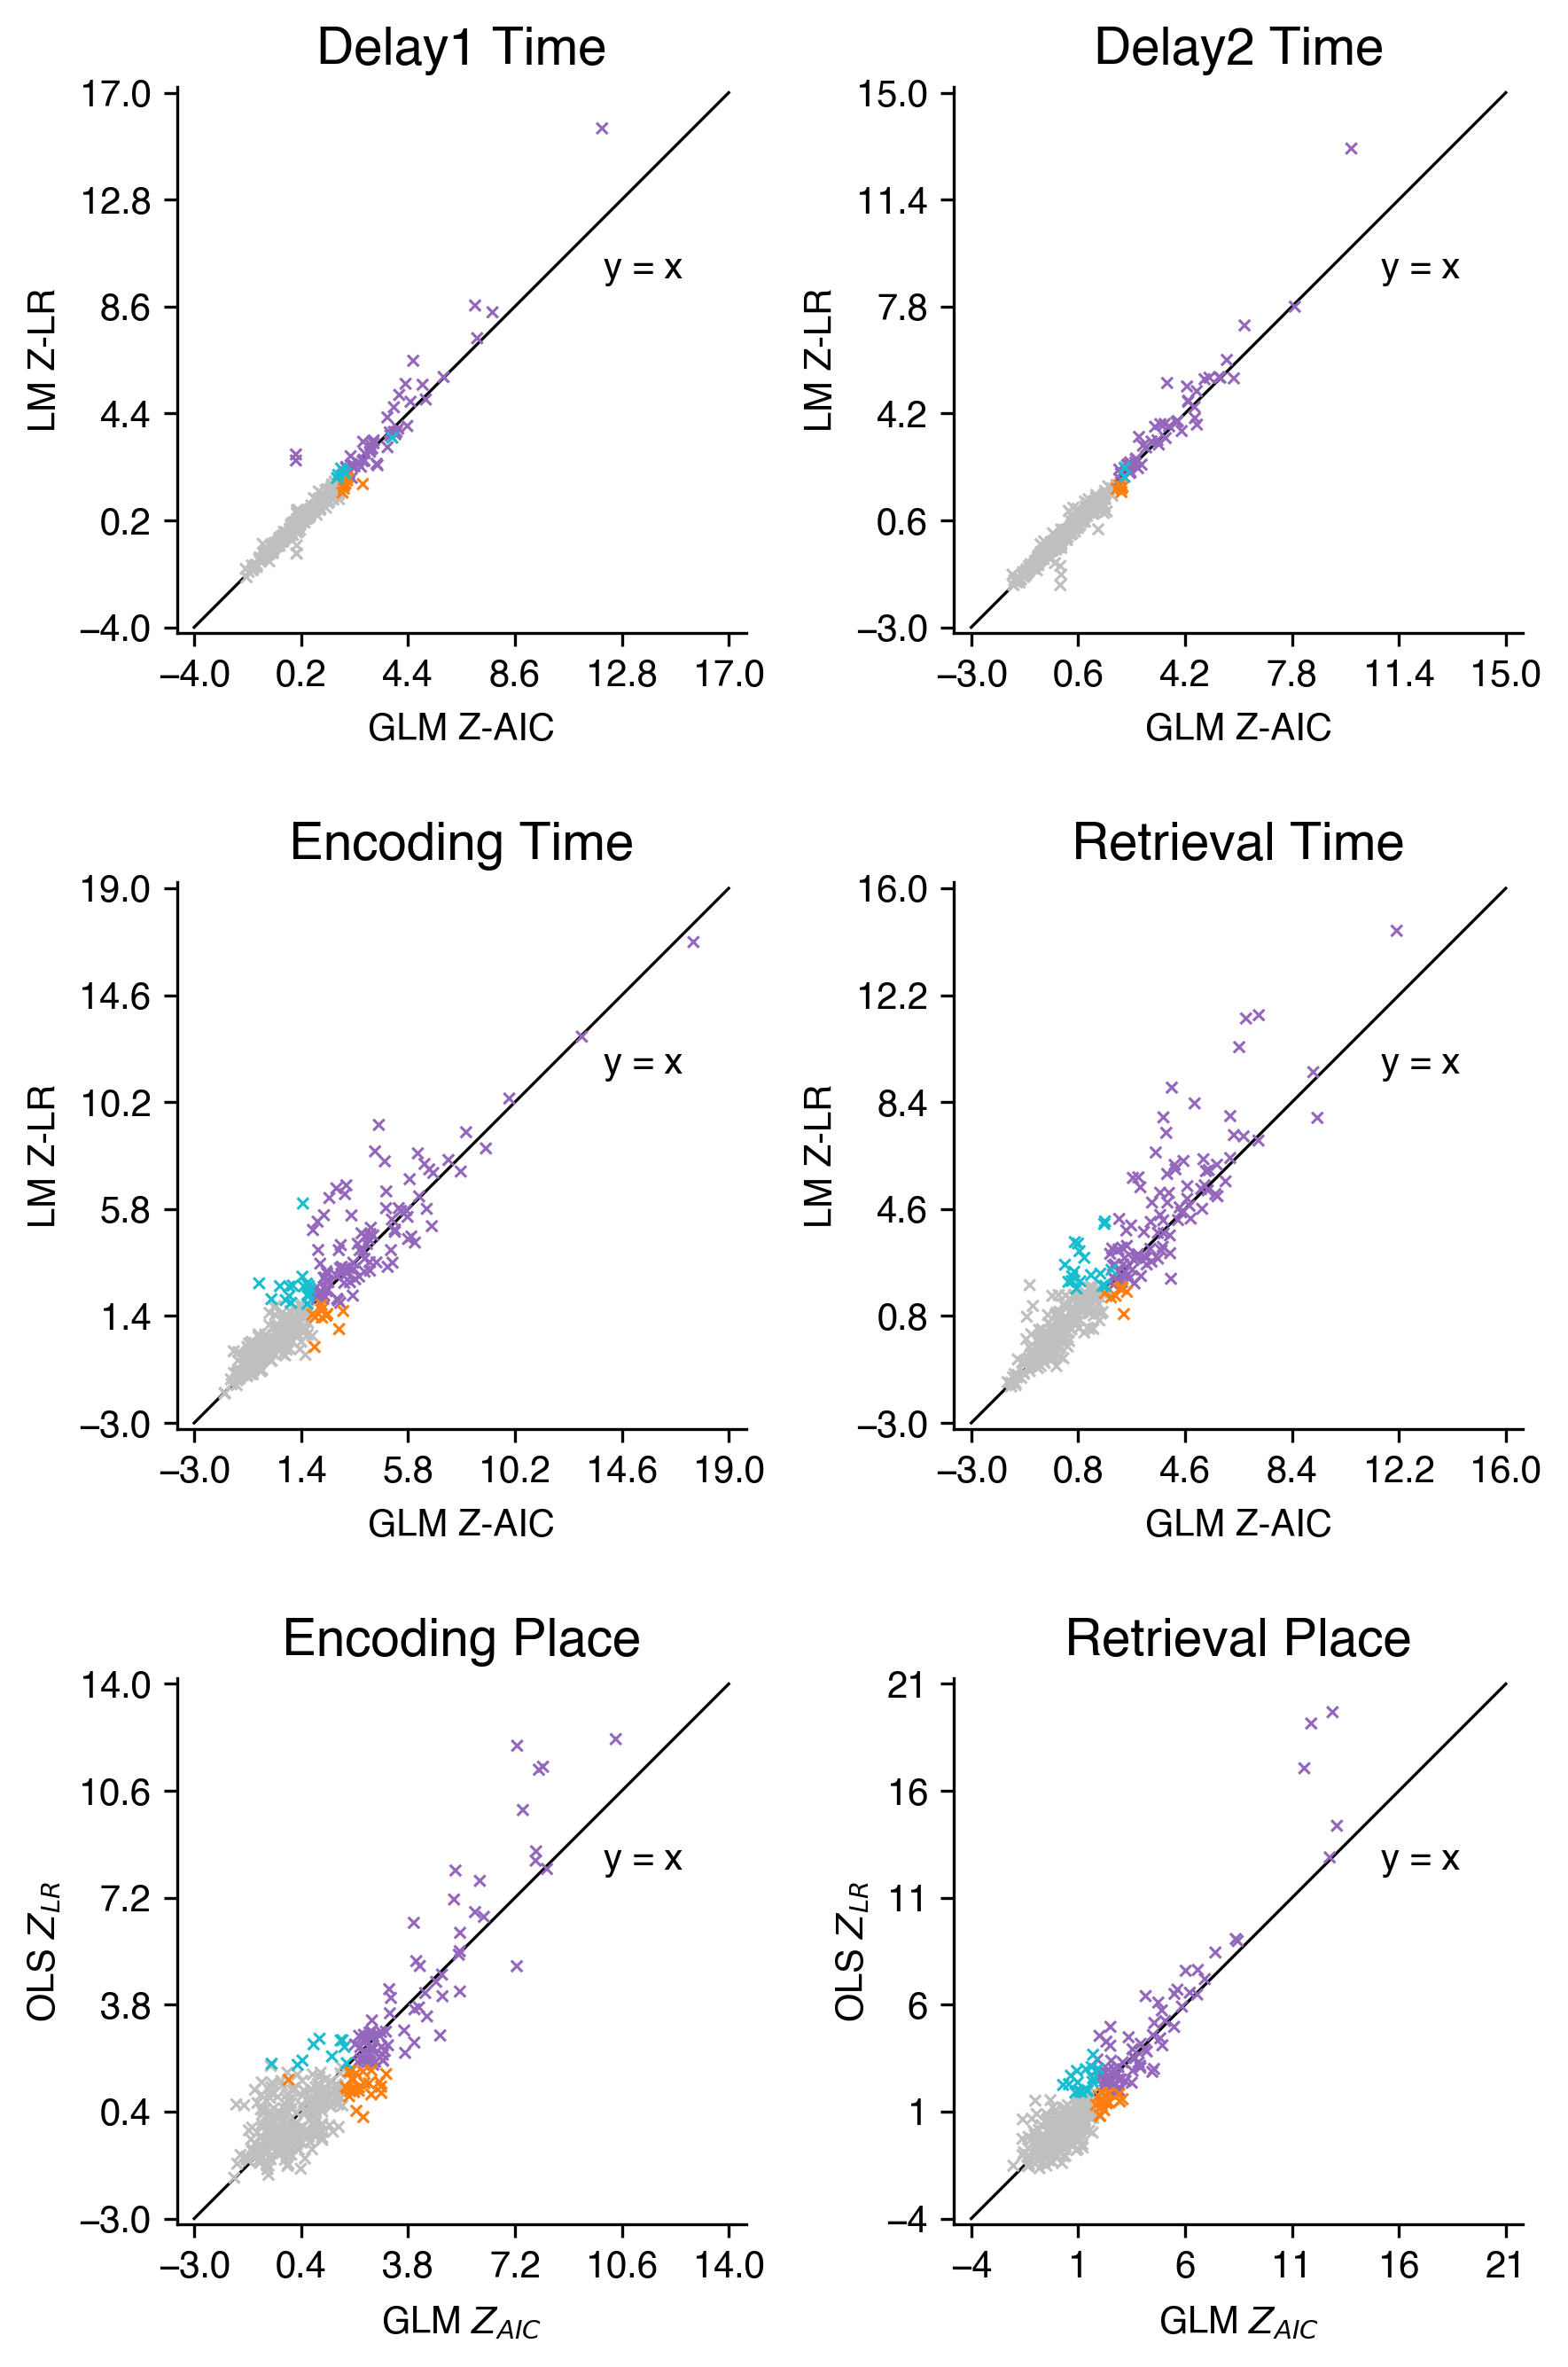

In [696]:
# Compare GLM and LM performance.
fig, ax = plt.subplots(3, 2, figsize=(6, 9), dpi=300)
ax = np.ravel(ax)

for iax, game_state in enumerate(['Delay1', 'Delay2', 'Encoding', 'Retrieval']):
    _df = df.dropna().query("(gameState=='{}') & (testvar=='time') & (full==['time', 'time_place'])".format(game_state))
    vmin = np.floor(np.min(_df.dropna()[['z_aic_diff', 'z_lr']].values)) - 1
    vmax = np.ceil(np.max(_df.dropna()[['z_aic_diff', 'z_lr']].values)) + 1
    ax[iax] = sns.scatterplot('z_aic_diff', 'z_lr', hue='sig_state', lw=0.8, alpha=1, marker='x',
                              edgecolor='k', palette=_cmap, legend=False, 
                              data=_df.sort_values('sig_state'), ax=ax[iax])
    ax[iax].set_aspect('equal', 'datalim')
    ax[iax].margins(0.1)
    ax[iax].plot([vmin, vmax], [vmin, vmax], lw=0.8, color='k', zorder=0)
    ax[iax].set_xlim([vmin, vmax])
    ax[iax].set_ylim(ax[iax].get_xlim())
    ax[iax].set_xticks(np.linspace(vmin, vmax, 6))
    ax[iax].set_yticks(ax[iax].get_xticks())
    ax[iax].minorticks_off()
    ax[iax].tick_params(labelsize=font['tick']-2)
    ax[iax].set_xlabel(r'GLM Z-AIC', fontsize=font['tick']-2, labelpad=5)
    ax[iax].set_ylabel(r'LM Z-LR', fontsize=font['tick']-2, labelpad=4)
    ax[iax].annotate(r'y = x', (0.75, 0.65), xycoords='axes fraction', color='k', fontsize=font['tick']-2)
    ax[iax].set_title(game_state + ' Time', fontsize=font['fig']-2)
    
for iax, game_state in enumerate(['Encoding', 'Retrieval']):
    iax += 4
    _df = df.dropna().query("(gameState=='{}') & (testvar=='place') & (full=='time_place')".format(game_state))
    vmin = np.floor(np.min(_df.dropna()[['z_aic_diff', 'z_lr']].values)) - 1
    vmax = np.ceil(np.max(_df.dropna()[['z_aic_diff', 'z_lr']].values)) + 1
    ax[iax] = sns.scatterplot('z_aic_diff', 'z_lr', hue='sig_state', lw=0.8, alpha=1, marker='x',
                              edgecolor='k', palette=_cmap, legend=False, 
                              data=_df.sort_values('sig_state'), ax=ax[iax])
    ax[iax].set_aspect('equal', 'datalim')
    ax[iax].margins(0.1)
    ax[iax].plot([vmin, vmax], [vmin, vmax], lw=0.8, color='k', zorder=0)
    ax[iax].set_xlim([vmin, vmax])
    ax[iax].set_ylim(ax[iax].get_xlim())
    ax[iax].set_xticks(np.linspace(vmin, vmax, 6))
    ax[iax].set_yticks(ax[iax].get_xticks())
    ax[iax].minorticks_off()
    ax[iax].tick_params(labelsize=font['tick']-2)
    ax[iax].set_xlabel(r'GLM $Z_{AIC}$', fontsize=font['tick']-2, labelpad=5)
    ax[iax].set_ylabel(r'OLS $Z_{LR}$', fontsize=font['tick']-2, labelpad=4)
    ax[iax].annotate(r'y = x', (0.75, 0.65), xycoords='axes fraction', color='k', fontsize=font['tick']-2)
    ax[iax].set_title(game_state + ' Place', fontsize=font['fig']-2)
    
fig.set_facecolor('w')
fig.tight_layout(h_pad=2)

In [824]:
_df = ols_pairs.groupby(['gameState', 'full', 'testvar']).agg({'sig05': np.mean}).reset_index()
_df.insert(0, 'model', _df.apply(lambda x: '-'.join((x['gameState'], x['testvar'], x['full'])), axis=1))

In [825]:
_df

model  gameState        full       testvar     sig05
0              Delay1-time-time     Delay1        time          time  0.167665
1              Delay2-time-time     Delay2        time          time  0.149701
2      Encoding-time-time_place   Encoding  time_place          time  0.338323
3     Encoding-place-time_place   Encoding  time_place         place  0.233533
4            Encoding-time-full   Encoding        full          time  0.233533
5           Encoding-place-full   Encoding        full         place  0.161677
6      Encoding-head_direc-full   Encoding        full    head_direc  0.104790
7    Encoding-gold_in_view-full   Encoding        full  gold_in_view  0.206587
8    Encoding-base_in_view-full   Encoding        full  base_in_view  0.116766
9     Retrieval-time-time_place  Retrieval  time_place          time  0.329341
10   Retrieval-place-time_place  Retrieval  time_place         place  0.263473
11          Retrieval-time-full  Retrieval        full          time  0.194611
12         Retrieval-place-full  Retrieval        full         place  0.212575
13    Retrieval-head_direc-full  Retrieval        full    head_direc  0.098802
14  Retrieval-gold_in_view-full  Retrieval        full  gold_in_view  0.101796
15  Retrieval-base_in_view-full  Retrieval        full  base_in_view  0.122754

In [799]:
def mean_sum(val):
    return '{} ({:.1%})'.format(np.sum(val), np.mean(val))

ols_pairs.groupby(['gameState', 'full', 'testvar']).agg({'sig05': mean_sum, 'sig025': mean_sum, 'sig0125': mean_sum, 'sig005': mean_sum})

sig05      sig025     sig0125  \
gameState full       testvar                                             
Delay1    time       time           56 (16.8%)  42 (12.6%)   27 (8.1%)   
Delay2    time       time           50 (15.0%)  41 (12.3%)   31 (9.3%)   
Encoding  time_place time          113 (33.8%)  95 (28.4%)  77 (23.1%)   
                     place          78 (23.4%)  60 (18.0%)  41 (12.3%)   
          full       time           78 (23.4%)  58 (17.4%)  46 (13.8%)   
                     place          54 (16.2%)  41 (12.3%)   31 (9.3%)   
                     head_direc     35 (10.5%)   24 (7.2%)   16 (4.8%)   
                     gold_in_view   69 (20.7%)  46 (13.8%)  35 (10.5%)   
                     base_in_view   39 (11.7%)   32 (9.6%)   23 (6.9%)   
Retrieval time_place time          110 (32.9%)  86 (25.7%)  71 (21.3%)   
                     place          88 (26.3%)  71 (21.3%)  55 (16.5%)   
          full       time           65 (19.5%)  44 (13.2%)  34 (10.2%)   
                     place          71 (21.3%)  49 (14.7%)   33 (9.9%)   
                     head_direc      33 (9.9%)   20 (6.0%)   13 (3.9%)   
                     gold_in_view   34 (10.2%)   20 (6.0%)   12 (3.6%)   
                     base_in_view   41 (12.3%)   24 (7.2%)   19 (5.7%)   

                                       sig005  
gameState full       testvar                   
Delay1    time       time           19 (5.7%)  
Delay2    time       time           23 (6.9%)  
Encoding  time_place time          56 (16.8%)  
                     place          30 (9.0%)  
          full       time          34 (10.2%)  
                     place          23 (6.9%)  
                     head_direc      9 (2.7%)  
                     gold_in_view   27 (8.1%)  
                     base_in_view   20 (6.0%)  
Retrieval time_place time          57 (17.1%)  
                     place         39 (11.7%)  
          full       time           22 (6.6%)  
                     place          25 (7.5%)  
                     head_direc      9 (2.7%)  
                     gold_in_view    8 (2.4%)  
                     base_in_view   16 (4.8%)

In [698]:
def mean_sum(val):
    return '{} ({:.1%})'.format(np.sum(val), np.mean(val))

glm_pairs.groupby(['gameState', 'full', 'testvar']).agg({'sig05': mean_sum, 'sig025': mean_sum, 'sig0125': mean_sum, 'sig005': mean_sum})

sig05      sig025     sig0125  \
gameState full       testvar                                             
Delay1    time       time           58 (17.4%)  39 (11.7%)   25 (7.5%)   
Delay2    time       time           53 (15.9%)  37 (11.1%)   29 (8.7%)   
Encoding  time_place time          105 (31.4%)  86 (25.7%)  72 (21.6%)   
                     place          94 (28.1%)  79 (23.7%)  55 (16.5%)   
          full       time           68 (20.4%)  48 (14.4%)  35 (10.5%)   
                     place          61 (18.3%)  41 (12.3%)   29 (8.7%)   
                     head_direc      25 (7.5%)   20 (6.0%)   16 (4.8%)   
                     gold_in_view   63 (18.9%)  53 (15.9%)   29 (8.7%)   
                     base_in_view   39 (11.7%)   31 (9.3%)   25 (7.5%)   
Retrieval time_place time          101 (30.2%)  82 (24.6%)  67 (20.1%)   
                     place          89 (26.6%)  73 (21.9%)  54 (16.2%)   
          full       time           57 (17.1%)  43 (12.9%)   25 (7.5%)   
                     place          58 (17.4%)  47 (14.1%)  36 (10.8%)   
                     head_direc      28 (8.4%)   15 (4.5%)   10 (3.0%)   
                     gold_in_view   37 (11.1%)   20 (6.0%)   13 (3.9%)   
                     base_in_view   42 (12.6%)   25 (7.5%)   21 (6.3%)   

                                       sig005  
gameState full       testvar                   
Delay1    time       time           20 (6.0%)  
Delay2    time       time           22 (6.6%)  
Encoding  time_place time          54 (16.2%)  
                     place         37 (11.1%)  
          full       time           28 (8.4%)  
                     place          22 (6.6%)  
                     head_direc      8 (2.4%)  
                     gold_in_view   22 (6.6%)  
                     base_in_view   20 (6.0%)  
Retrieval time_place time          53 (15.9%)  
                     place         43 (12.9%)  
          full       time           17 (5.1%)  
                     place          23 (6.9%)  
                     head_direc      5 (1.5%)  
                     gold_in_view    5 (1.5%)  
                     base_in_view   17 (5.1%)

In [7]:
from time_cells.time_bin_analysis import _shift_spikes, _shuffle_spikes, lr_test

In [6]:
def compare_sig(model_pairs,
                game_states,
                testvar,
                full_model,
                sigcol='sig025',
                verbose=True):
    """Compare significant neurons within and between game states."""
    game_states = list(game_states)
    assert len(game_states) == 2
    
    n_neurons = np.unique(model_pairs.query("(gameState==['Delay1', 'Delay2'])")['subj_sess_unit']).size
    sig_cells = {}
    sig_cells['either'] = np.unique(model_pairs.query("(gameState=={}) & (testvar=='{}') & (full=='{}') & ({}==True)"
                                                  .format(game_states, testvar, full_model, sigcol))['subj_sess_unit'])
    for game_state in game_states:
        sig_cells[game_state] = np.unique(model_pairs.query("(gameState=='{}') & (testvar=='{}') & (full=='{}') & ({}==True)"
                                                 .format(game_state, testvar, full_model, sigcol))['subj_sess_unit'])
    sig_cells['both'] = np.array([unit for unit in sig_cells[game_states[0]] if unit in sig_cells[game_states[1]]])
    
    if verbose:
        msg = ('-' * 50 + '\n') + '{} model, testing {}, {}\n'.format(full_model, testvar, sigcol) + ('-' * 50 + '\n')
        for game_state in game_states:
            msg += '{}/{} {} ({:.1%})\n'.format(sig_cells[game_state].size, n_neurons, game_state, sig_cells[game_state].size / n_neurons)
        msg += '{}/{} either ({:.1%})\n'.format(sig_cells['either'].size, n_neurons, sig_cells['either'].size / n_neurons)
        msg += '{}/{} both ({:.1%})'.format(sig_cells['both'].size, n_neurons, sig_cells['both'].size / n_neurons)
        msg += ', or {}/{} ({:.1%})\n'.format(sig_cells['both'].size, sig_cells['either'].size, sig_cells['both'].size / sig_cells['either'].size)
        ind_prob = (sig_cells[game_states[0]].size / n_neurons) * (sig_cells[game_states[1]].size / n_neurons)
        msg += '{:.1f}/{} both ({:.1%}) predicted under ind. prob.\n'.format(ind_prob * n_neurons, n_neurons, ind_prob)
        print(msg)
        
    return sig_cells

In [725]:
sigcol = 'sig05'
model_pairs = ols_pairs

sig_cells = od([])
sig_cells['delay'] = compare_sig(model_pairs, ['Delay1', 'Delay2'], 'time', 'time', sigcol=sigcol)
sig_cells['nav_time_timeplace'] = compare_sig(model_pairs, ['Encoding', 'Retrieval'], 'time', 'time_place', sigcol=sigcol)
sig_cells['nav_place_timeplace'] = compare_sig(model_pairs, ['Encoding', 'Retrieval'], 'place', 'time_place', sigcol=sigcol)
sig_cells['nav_time_full'] = compare_sig(model_pairs, ['Encoding', 'Retrieval'], 'time', 'full', sigcol=sigcol)
sig_cells['nav_place_full'] = compare_sig(model_pairs, ['Encoding', 'Retrieval'], 'place', 'full', sigcol=sigcol)
sig_cells['nav_hd_full'] = compare_sig(model_pairs, ['Encoding', 'Retrieval'], 'head_direc', 'full', sigcol=sigcol)
sig_cells['nav_gov_full'] = compare_sig(model_pairs, ['Encoding', 'Retrieval'], 'gold_in_view', 'full', sigcol=sigcol)

--------------------------------------------------
time model, testing time, sig05
--------------------------------------------------
56/334 Delay1 (16.8%)
50/334 Delay2 (15.0%)
89/334 either (26.6%)
17/334 both (5.1%), or 17/89 (19.1%)
8.4/334 both (2.5%) predicted under ind. prob.

--------------------------------------------------
time_place model, testing time, sig05
--------------------------------------------------
113/334 Encoding (33.8%)
110/334 Retrieval (32.9%)
169/334 either (50.6%)
54/334 both (16.2%), or 54/169 (32.0%)
37.2/334 both (11.1%) predicted under ind. prob.

--------------------------------------------------
time_place model, testing place, sig05
--------------------------------------------------
78/334 Encoding (23.4%)
88/334 Retrieval (26.3%)
122/334 either (36.5%)
44/334 both (13.2%), or 44/122 (36.1%)
20.6/334 both (6.2%) predicted under ind. prob.

--------------------------------------------------
full model, testing time, sig05
----------------------------

In [8]:
# Compare each neuron's time coding strength between game state pairs.
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
game_state_pairs = [('Delay1', 'Delay2'),
                    ('Delay1', 'Encoding'),
                    ('Delay1', 'Retrieval'),
                    ('Delay2', 'Encoding'),
                    ('Delay2', 'Retrieval'),
                    ('Encoding', 'Retrieval')]
sig_col = 'sig05'

cols = ['subj_sess', 'neuron', 'gameState1', 'gameState2', 'zlr1', 'zlr2', 'sig1', 'sig2']
subj_sess_units = list(np.unique(ols_pairs['subj_sess_unit']))
time_strength = []
for subj_sess_unit in subj_sess_units:
    subj_sess, chan, unit = subj_sess_unit.split('-')
    neuron = '{}-{}'.format(chan, unit)
    for gs1, gs2 in game_state_pairs:
        qry1 = "(subj_sess_unit=='{}') & (gameState=='{}') & (testvar=='time') & (full==['time', 'full'])".format(subj_sess_unit, gs1)
        qry2 = "(subj_sess_unit=='{}') & (gameState=='{}') & (testvar=='time') & (full==['time', 'full'])".format(subj_sess_unit, gs2)
        time_strength.append([subj_sess,
                              neuron,
                              gs1,
                              gs2,
                              ols_pairs.query(qry1).iloc[0]['z_lr'], 
                              ols_pairs.query(qry2).iloc[0]['z_lr'],
                              ols_pairs.query(qry1).iloc[0][sig_col], 
                              ols_pairs.query(qry2).iloc[0][sig_col]])
        
time_strength = pd.DataFrame(time_strength, columns=cols)

# Determine if each neuron is a time cell, place cell, both, or neither.
time_strength['sig_state'] = 0
time_strength.loc[(time_strength['sig1']==True) & (time_strength['sig2']==False), 'sig_state'] = 2
time_strength.loc[(time_strength['sig1']==False) & (time_strength['sig2']==True), 'sig_state'] = 3
time_strength.loc[(time_strength['sig1']==True) & (time_strength['sig2']==True), 'sig_state'] = 1

print('time_strength:', time_strength.shape)

time_strength: (2004, 9)


In [15]:
jaccard_score(_df['sig1'], _df['sig2'])

0.211864406779661

In [5]:
def pearson_permtest(v1, 
                     v2, 
                     n_perm=1000):
    """Return the Pearson correlation between v1 and v2.
    
    If n_perm > 0, also calculate a Z-score and p-value
    for the Pearson correlation, relative to a null distribution
    of shuffled values.
    
    Parameters
    ----------
    v1 : array
        Boolean vector
    v2 : array
        Boolean vector of equal length to v1
    n_perm : int
        The number of times that v1 will be shuffled
        in place and the Pearson correlation recalculated.
        
    Returns
    -------
    pearson : float
        The Pearson correlation between v1 and v2.
    pearson_z : float
        Z-scored Pearson correlation, versus the null distribution.
    pval : float
        The empirical p-value.
    """
    pearson = stats.pearsonr(v1, v2)[0]
    pearson_z = None
    pval = None
    
    if n_perm > 0:
        pearson_null = []
        for _ in range(n_perm):
            np.random.shuffle(v1)
            pearson_null.append(stats.pearsonr(v1, v2)[0])
        pearson_null = np.array(pearson_null)
        _mean = np.mean(pearson_null)
        _std = np.std(pearson_null)
        pearson_z = (pearson - _mean) / _std
        pval_ind = np.sum(np.abs(pearson_null)>=np.abs(pearson))
        pval = (1 + pval_ind) / (1 + n_perm)
    
    return pearson, pearson_z, pval

In [6]:
def jaccard_permtest(v1, 
                     v2, 
                     n_perm=1000):
    """Return the Jaccard score between v1 and v2.
    
    If n_perm > 0, also calculate a Z-score and p-value
    for the Jaccard score, relative to a null distribution
    of shuffled values.
    
    Parameters
    ----------
    v1 : array
        Boolean vector
    v2 : array
        Boolean vector of equal length to v1
    n_perm : int
        The number of times that v1 will be shuffled
        in place and the Jaccard score recalculated.
        
    Returns
    -------
    jaccard : float
        The Jaccard score between v1 and v2 (0 to 1).
    jaccard_z : float
        Z-scored Jaccard score, versus the null distribution.
    pval : float
        The empirical p-value.
    """
    jaccard = jaccard_score(v1, v2)
    jaccard_z = None
    pval = None
    
    if n_perm > 0:
        jaccard_null = []
        for _ in range(n_perm):
            np.random.shuffle(v1)
            jaccard_null.append(jaccard_score(v1, v2))
        jaccard_null = np.array(jaccard_null)
        _mean = np.mean(jaccard_null)
        _std = np.std(jaccard_null)
        jaccard_z = (jaccard - _mean) / _std
        pval_ind = np.sum(jaccard_null>=jaccard)
        pval = (1 + pval_ind) / (1 + n_perm)
    
    return jaccard, jaccard_z, pval

In [27]:
jaccard, jaccard_z, pval = jaccard_permtest(_df['sig1'].copy().values, _df['sig2'].copy().values)
print(gs1, gs2, jaccard, jaccard_z, pval)

Encoding Retrieval 0.211864406779661 3.4479646039559317 0.002997002997002997


In [33]:
ols_pairs.columns

Index(['subj_sess_unit', 'subj_sess', 'neuron', 'gameState', 'testvar',
       'reduced', 'full', 'llf_full', 'lr', 'z_lr', 'df', 'params_full',
       'chi_pval', 'emp_pval', 'null_hist', 'icpt', 'time-2', 'sig05',
       'sig025', 'sig0125', 'sig005', 'time-3', 'time-4', 'time-5', 'time-6',
       'time-7', 'time-8', 'time-9', 'time-10', 'place-C_Hall',
       'place-NE_Hall', 'place-NE_Room', 'place-NW_Hall', 'place-NW_Room',
       'place-N_Passage', 'place-SE_Hall', 'place-SE_Room', 'place-SW_Hall',
       'place-SW_Room', 'place-S_Passage', 'hd-N', 'hd-S', 'hd-W', 'is_moving',
       'base_in_view', 'gold_in_view', 'dig_performed', 'trial-10', 'trial-11',
       'trial-12', 'trial-13', 'trial-14', 'trial-15', 'trial-16', 'trial-17',
       'trial-18', 'trial-19', 'trial-20', 'trial-21', 'trial-22', 'trial-23',
       'trial-24', 'trial-25', 'trial-26', 'trial-27', 'trial-28', 'trial-29',
       'trial-2', 'trial-30', 'trial-31', 'trial-32', 'trial-33', 'trial-34',
       'trial-3

In [41]:
stats.pearsonr([ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
                       [ols_pairs.query("(gameState=='Delay2') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells])

(0.3920544636492217, 0.00014490175405439235)

0.3920544636492217 3.7573717064260466 0.000999000999000999


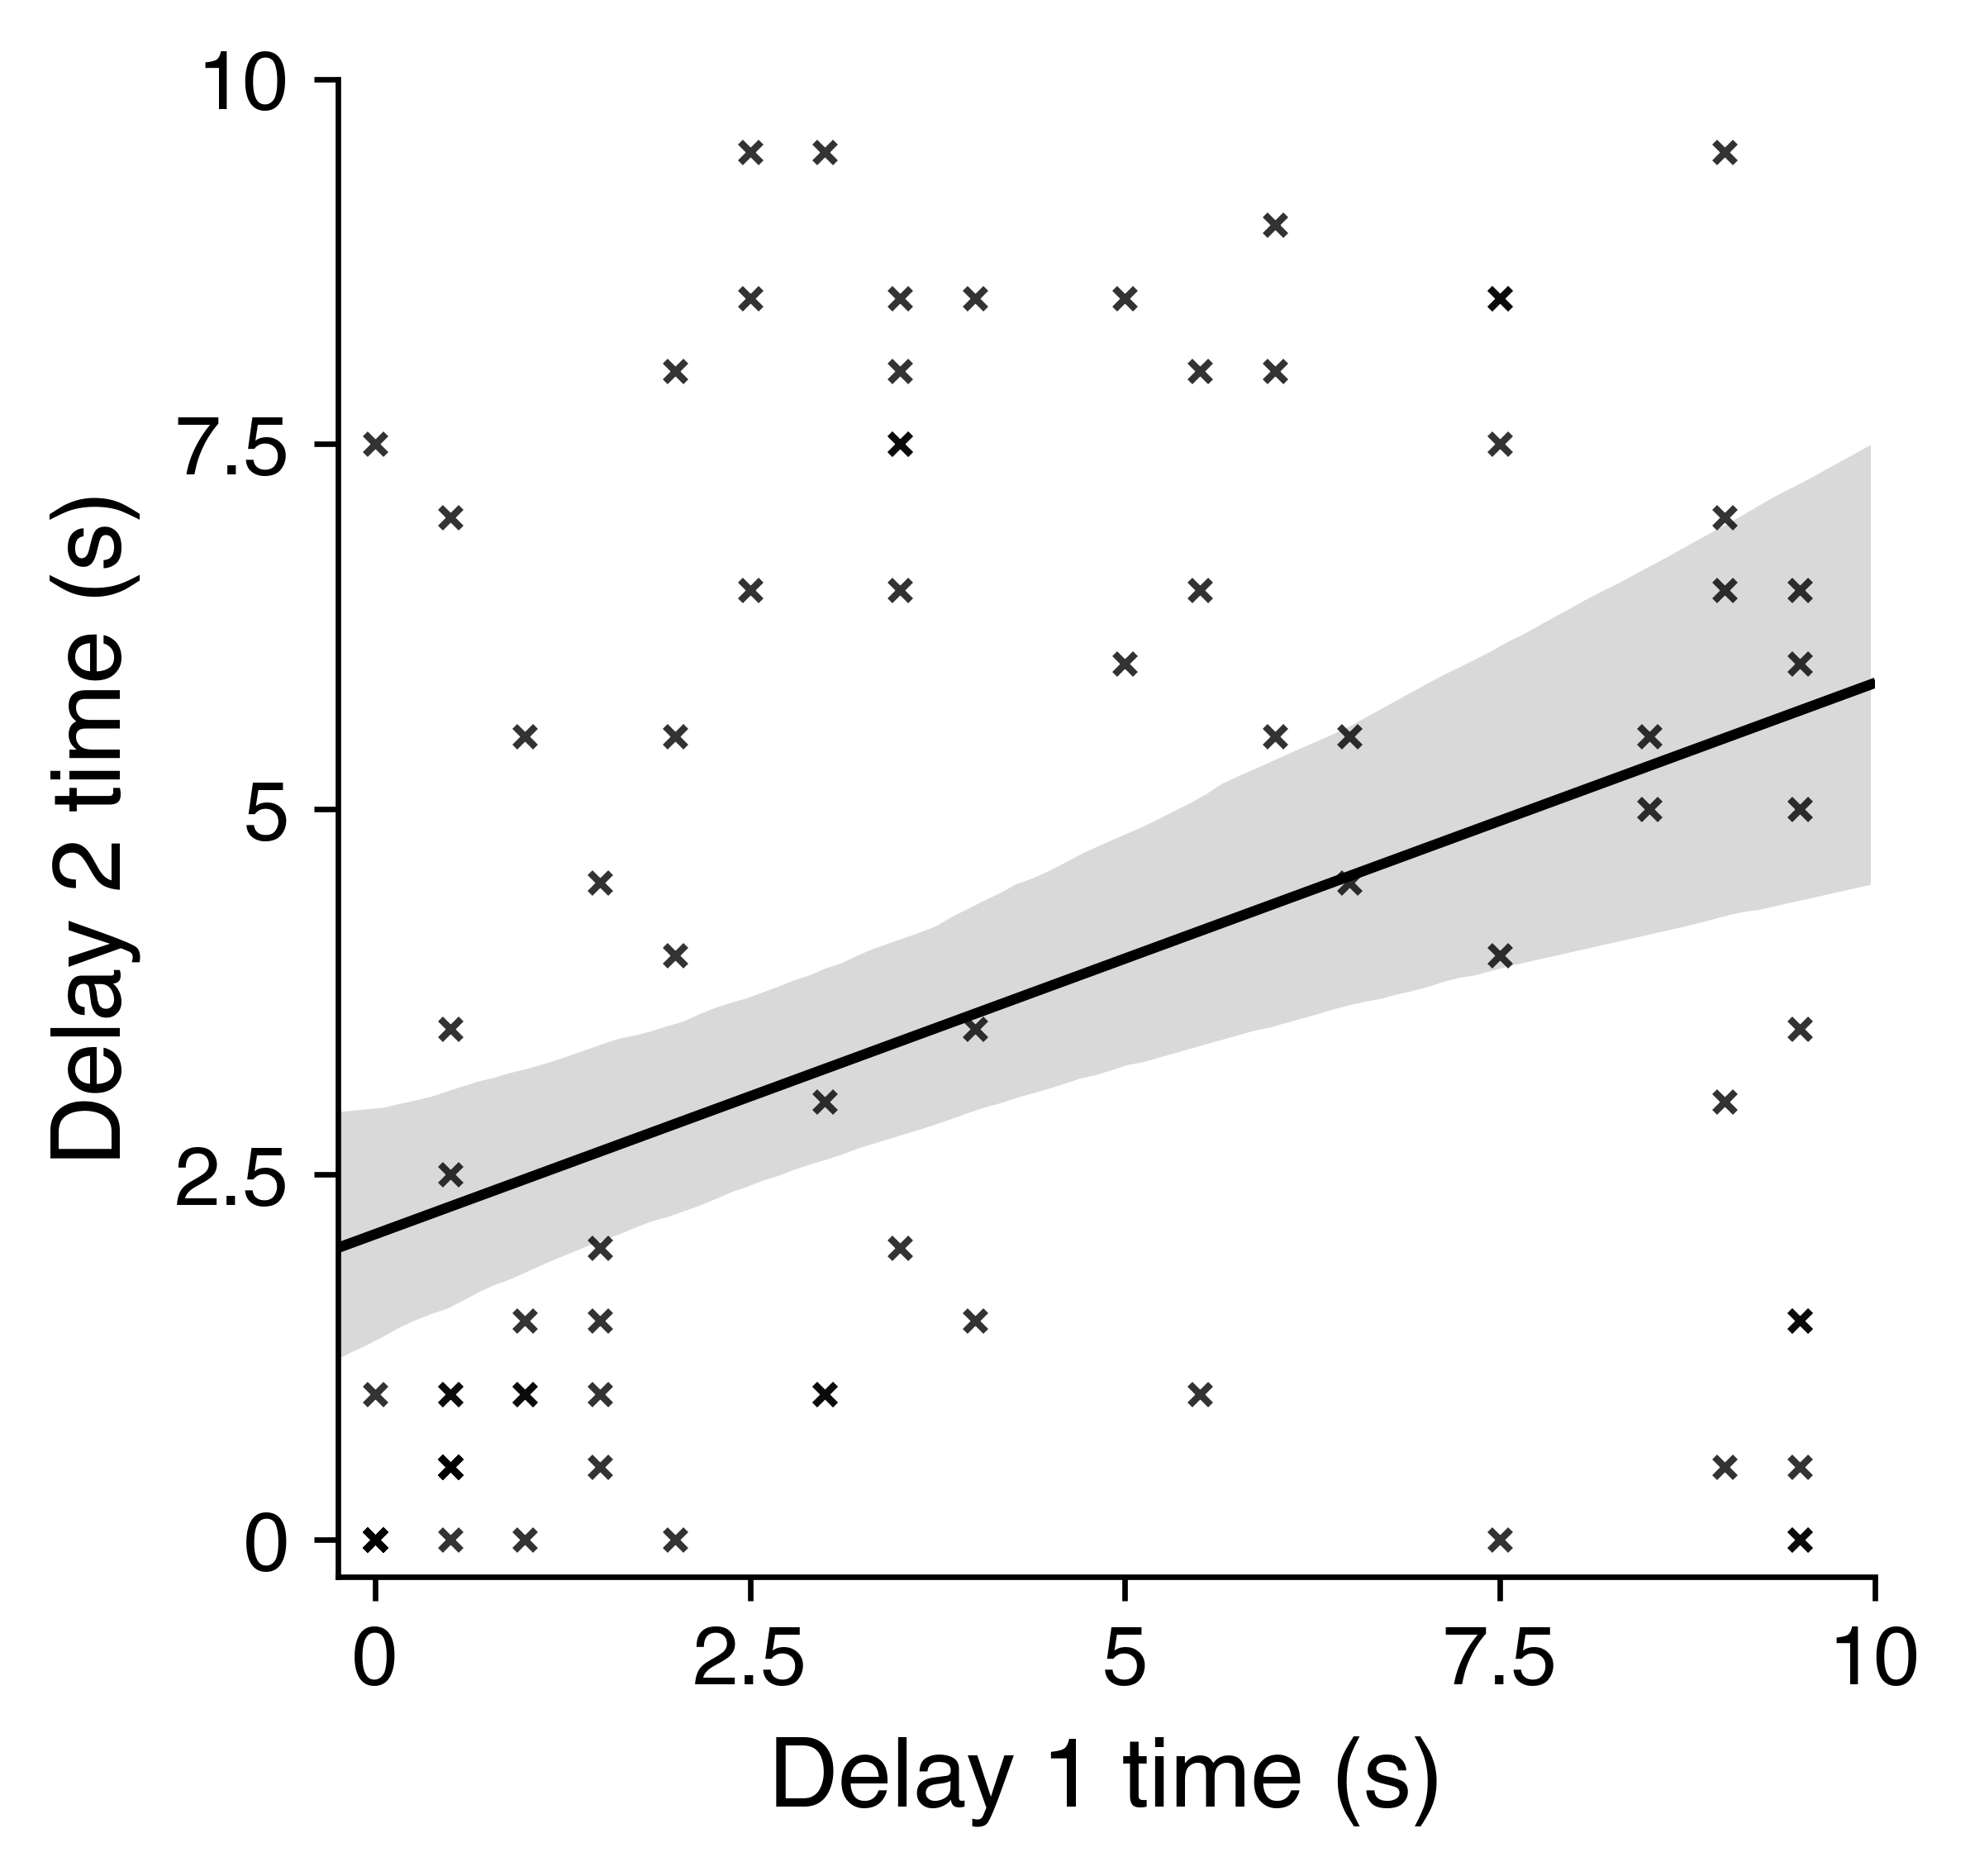

In [46]:
n_perm = 1000

plt.close()
fig, ax = plt.subplots(figsize=(4, 4), dpi=600)

delay_time_cells = list(ols_pairs.query("(sig==True) & (gameState==['Delay1', 'Delay2'])")['subj_sess_unit'].unique())

# r, p = stats.pearsonr([ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
#                       [ols_pairs.query("(gameState=='Delay2') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells])
# print(r, p)
pearson, pearson_z, pval = pearson_permtest([ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
                                            [ols_pairs.query("(gameState=='Delay2') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
                                            n_perm=n_perm)
print(pearson, pearson_z, pval)

sns.regplot([ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
            [ols_pairs.query("(gameState=='Delay2') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
            ax=ax, marker='x', color='k')
ax.set_xlim([-0.5, 20])
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xticklabels([0, 2.5, 5, 7.5, 10], fontsize=font['tick'])
ax.set_xlabel('Delay 1 time (s)', fontsize=font['label'], labelpad=5)
ax.set_ylim([-0.5, 20])
ax.set_yticks([0, 5, 10, 15, 20])
ax.set_yticklabels([0, 2.5, 5, 7.5, 10], fontsize=font['tick'])
ax.set_ylabel('Delay 2 time (s)', fontsize=font['label'], labelpad=5)
#ax.annotate('$r = {:.2f}$'.format(pearson), (0.1, 0.9), xycoords='axes fraction')
fig.show()

Delay1 Delay2 0.19101123595505617 3.8394302329962073 0.000999000999000999
Delay1 Encoding 0.16521739130434782 2.0247728047004183 0.03696303696303696
Delay1 Retrieval 0.19801980198019803 3.6180123884849924 0.002997002997002997
Delay2 Encoding 0.14285714285714285 1.5092612387153959 0.1018981018981019
Delay2 Retrieval 0.15 2.263334792065022 0.028971028971028972
Encoding Retrieval 0.211864406779661 3.395900079390276 0.001998001998001998


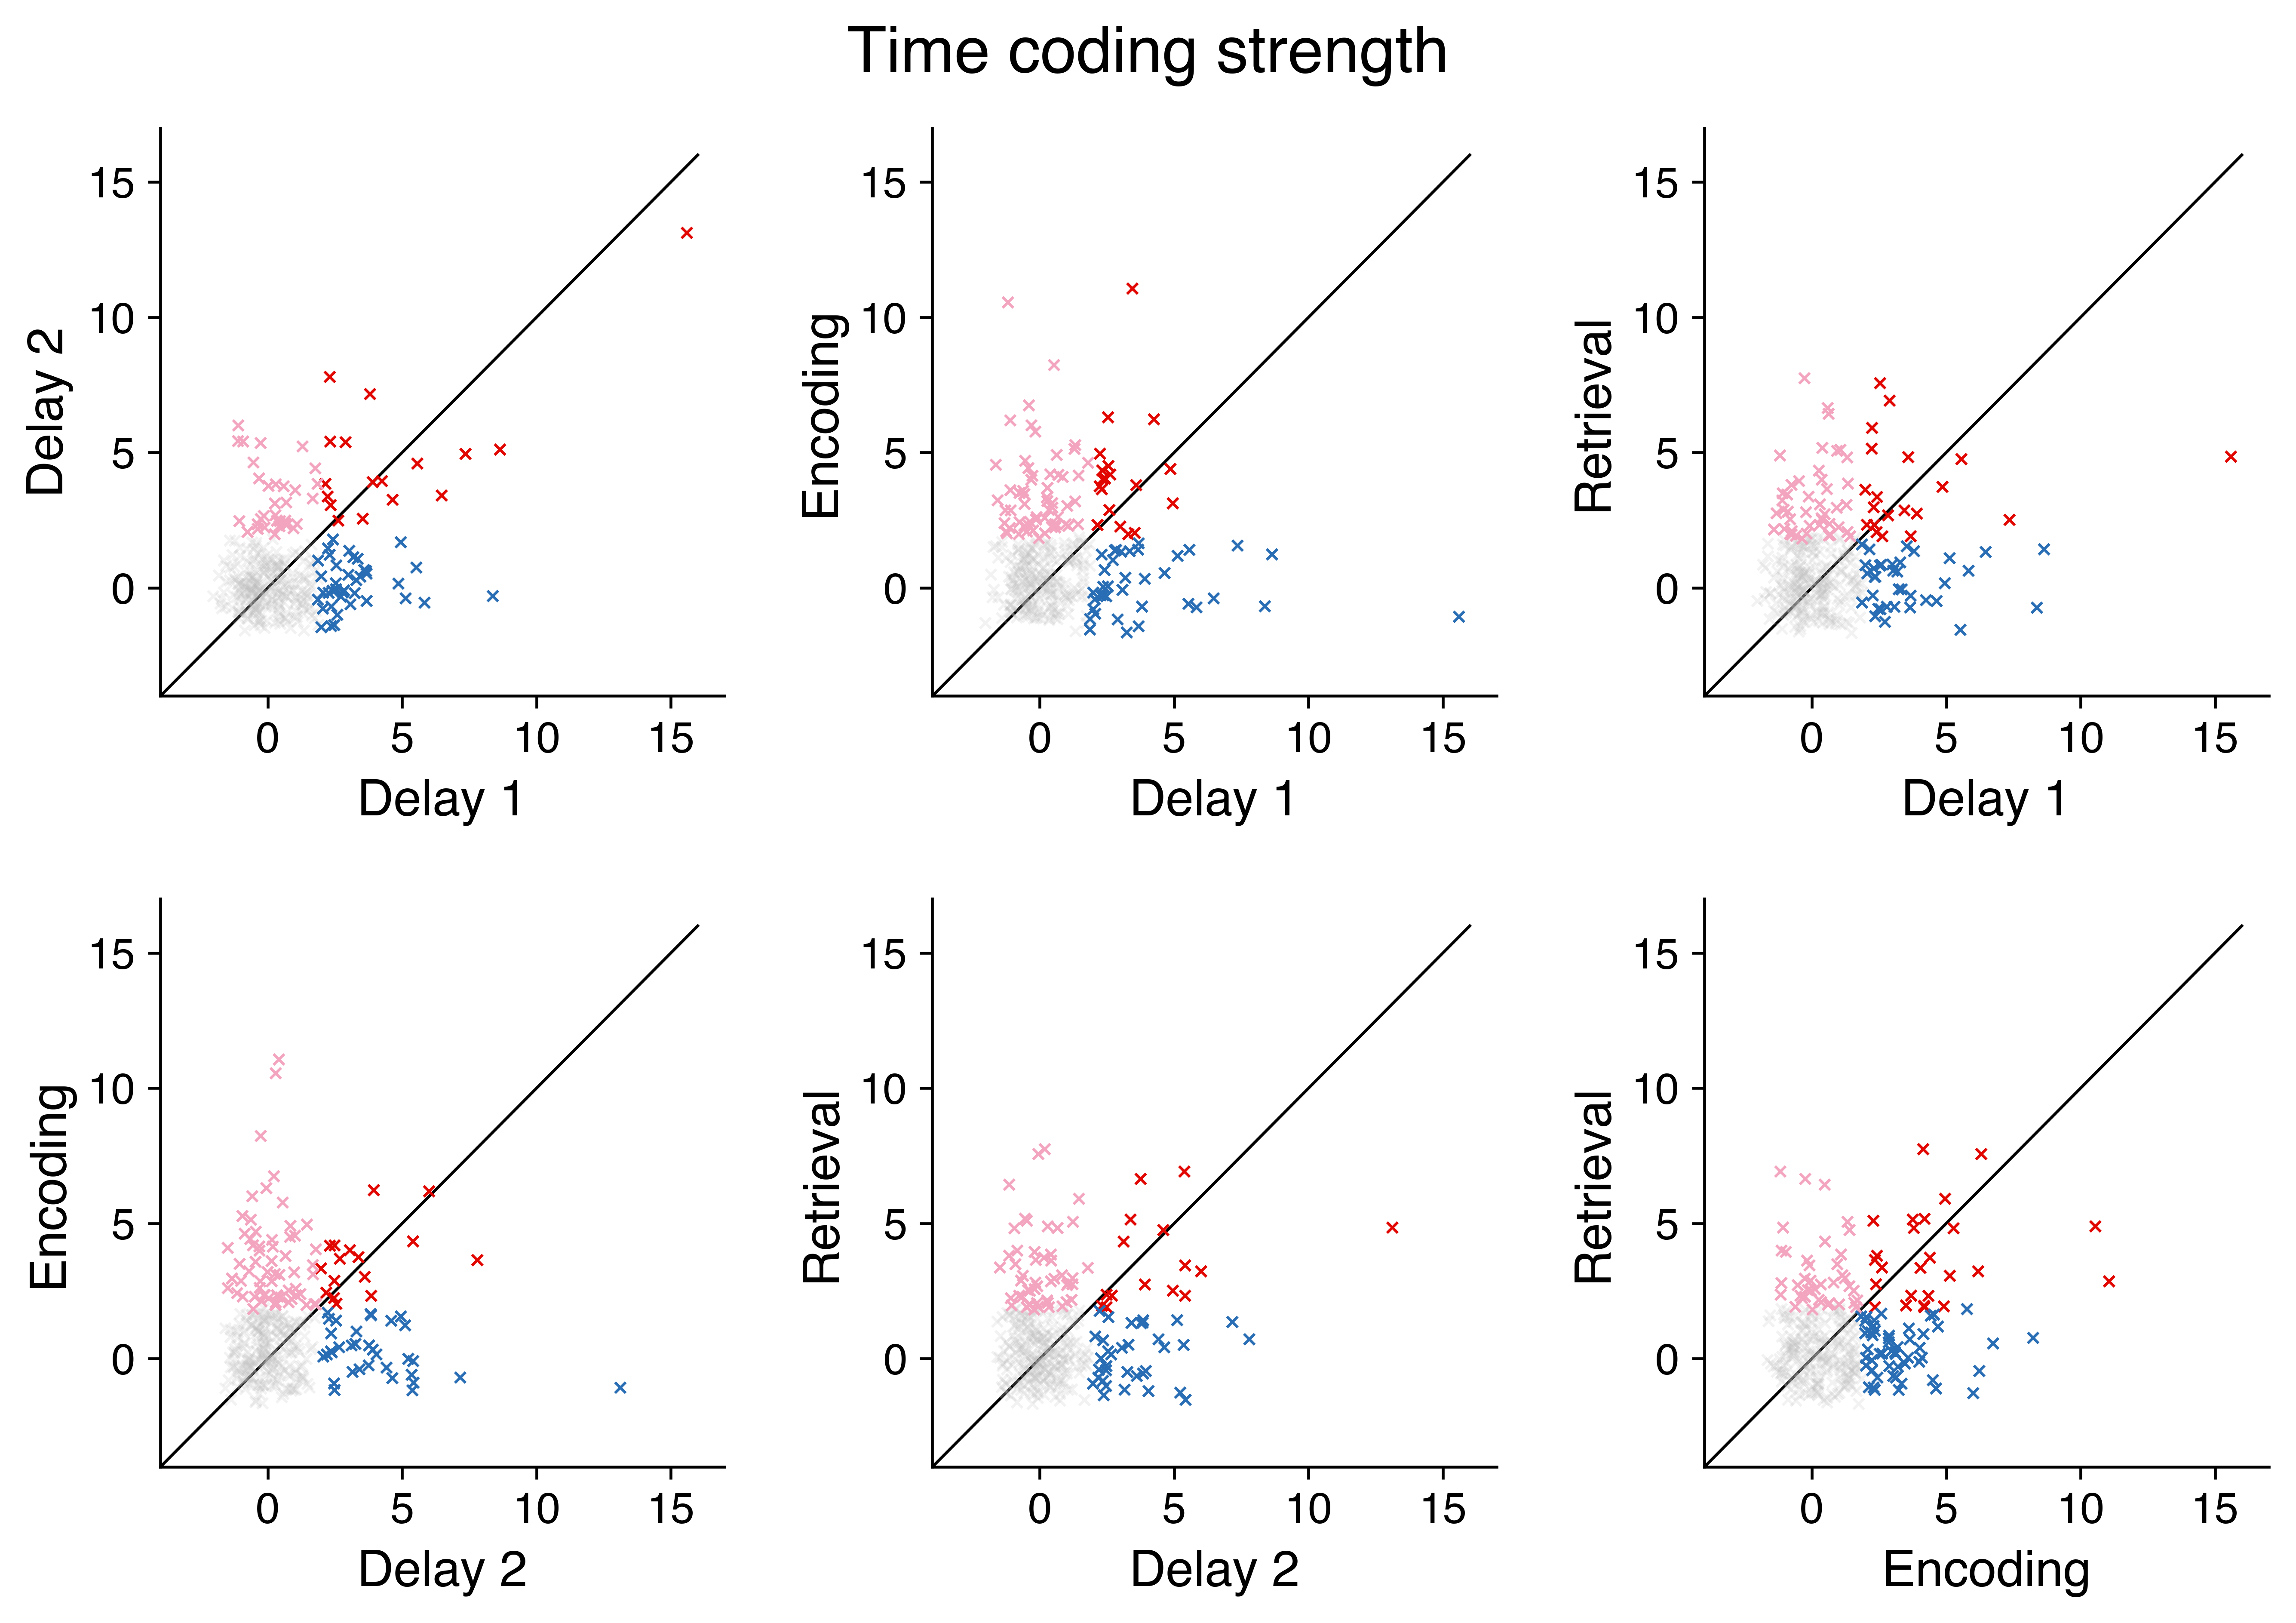

In [45]:
# Plot Z-scored likelihood rateios for Delay1 vs Delay2 time.
n_perm = 1000
fig, ax = plt.subplots(2, 3, figsize=(9, 6), dpi=600)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray #bebebe
        1: (225, 6, 0), # red #e10600
        2: (41, 110, 180), # blue #296eb4
        3: (243, 165, 191)} # pink #f3a5bf
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
    
iax = 0
vmin = -4
vmax = 17
for gs1, gs2 in game_state_pairs:
    _df = time_strength.query("(gameState1=='{}') & (gameState2=='{}')".format(gs1, gs2))
#     vmin = np.floor(np.min(_df.dropna()[['zlr1', 'zlr2']].to_numpy())) - 1
#     vmax = np.ceil(np.max(_df.dropna()[['zlr1', 'zlr2']].to_numpy())) + 1
#     rho, pval = stats.spearmanr(_df.query("(sig_state!=0)")['zlr1'], _df.query("(sig_state!=0)")['zlr2'])
#     rval, pval2 = stats.pearsonr(_df.query("(sig_state!=0)")['zlr1'], _df.query("(sig_state!=0)")['zlr2'])
    jaccard = jaccard_score(_df['sig1'], _df['sig2'])
    jaccard, jaccard_z, pval = jaccard_permtest(_df['sig1'].copy().values, 
                                                _df['sig2'].copy().values,
                                                n_perm=n_perm)
    print(gs1, gs2, jaccard, jaccard_z, pval)
    _cmap = {_i: cmap[_i] for _i in _df['sig_state'].unique() if (_i!=0)}
    ax[iax].plot(np.arange(vmin, vmax), np.arange(vmin, vmax), color='k', lw=0.8, zorder=0)
    ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', alpha=0.2, lw=0.4, marker='x',
                              edgecolor='k', palette=[cmap[0]], legend=False, 
                              data=_df.query("(sig_state==0)"), ax=ax[iax])
    ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', alpha=1, lw=0.8, marker='x',
                              edgecolor='k', palette=_cmap, legend=False, 
                              data=_df.query("(sig_state!=0)").sort_values('sig_state'), ax=ax[iax])
    ax[iax].set_xlim([vmin, vmax])
    ax[iax].set_ylim(ax[iax].get_xlim())
    ax[iax].tick_params(labelsize=font['tick'])
    ax[iax].set_xticks(np.linspace(0, 15, 4))
    ax[iax].set_yticks(ax[iax].get_xticks())
    ax[iax].set_xlabel(gs1.replace('Delay', 'Delay '), fontsize=font['label'], labelpad=5)
    ax[iax].set_ylabel(gs2.replace('Delay', 'Delay '), fontsize=font['label'], labelpad=4)
#     ax[iax].annotate(r'$\rho = {:.2f}$'.format(rho), (0.1, 0.85), 
#                      xycoords='axes fraction', color='k', fontsize=font['tick']-2)
    iax += 1
    
fig.suptitle('Time coding strength', fontsize=font['fig'] + 2, y=1.04)
fig.set_facecolor('w')
fig.tight_layout(w_pad=2, h_pad=2)
fig.show()

In [769]:
# Compare each neuron's time coding strength between game state pairs.
testvar_pairs = [('time', 'place'),
                 ('time', 'head_direc'),
                 ('time', 'base_in_view'),
                 ('time', 'gold_in_view'),
                 ('place', 'head_direc'),
                 ('place', 'base_in_view'),
                 ('place', 'gold_in_view'),
                 ('head_direc', 'base_in_view'),
                 ('head_direc', 'gold_in_view'),
                 ('base_in_view', 'gold_in_view')]
sig_col = 'sig05'

cols = ['subj_sess', 'neuron', 'gameState', 'testvar1', 'testvar2', 'zlr1', 'zlr2', 'sig1', 'sig2']
subj_sess_units = list(np.unique(ols_pairs['subj_sess_unit']))
param_strength = []
for subj_sess_unit in subj_sess_units:
    subj_sess, chan, unit = subj_sess_unit.split('-')
    neuron = '{}-{}'.format(chan, unit)
    for game_state in ['Encoding', 'Retrieval']:
        for tv1, tv2 in testvar_pairs:
            qry1 = "(subj_sess_unit=='{}') & (gameState=='{}') & (testvar=='{}') & (full=='full')".format(subj_sess_unit, game_state, tv1)
            qry2 = "(subj_sess_unit=='{}') & (gameState=='{}') & (testvar=='{}') & (full=='full')".format(subj_sess_unit, game_state, tv2)
            param_strength.append([subj_sess,
                                   neuron,
                                   game_state,
                                   tv1,
                                   tv2,
                                   ols_pairs.query(qry1).iloc[0]['z_lr'], 
                                   ols_pairs.query(qry2).iloc[0]['z_lr'],
                                   ols_pairs.query(qry1).iloc[0][sig_col], 
                                   ols_pairs.query(qry2).iloc[0][sig_col]])
        
param_strength = pd.DataFrame(param_strength, columns=cols)

# Determine if each neuron is a time cell, place cell, both, or neither.
param_strength['sig_state'] = 0
param_strength.loc[(param_strength['sig1']==True) & (param_strength['sig2']==False), 'sig_state'] = 2
param_strength.loc[(param_strength['sig1']==False) & (param_strength['sig2']==True), 'sig_state'] = 3
param_strength.loc[(param_strength['sig1']==True) & (param_strength['sig2']==True), 'sig_state'] = 1

print('param_strength:', param_strength.shape)

param_strength: (6680, 10)


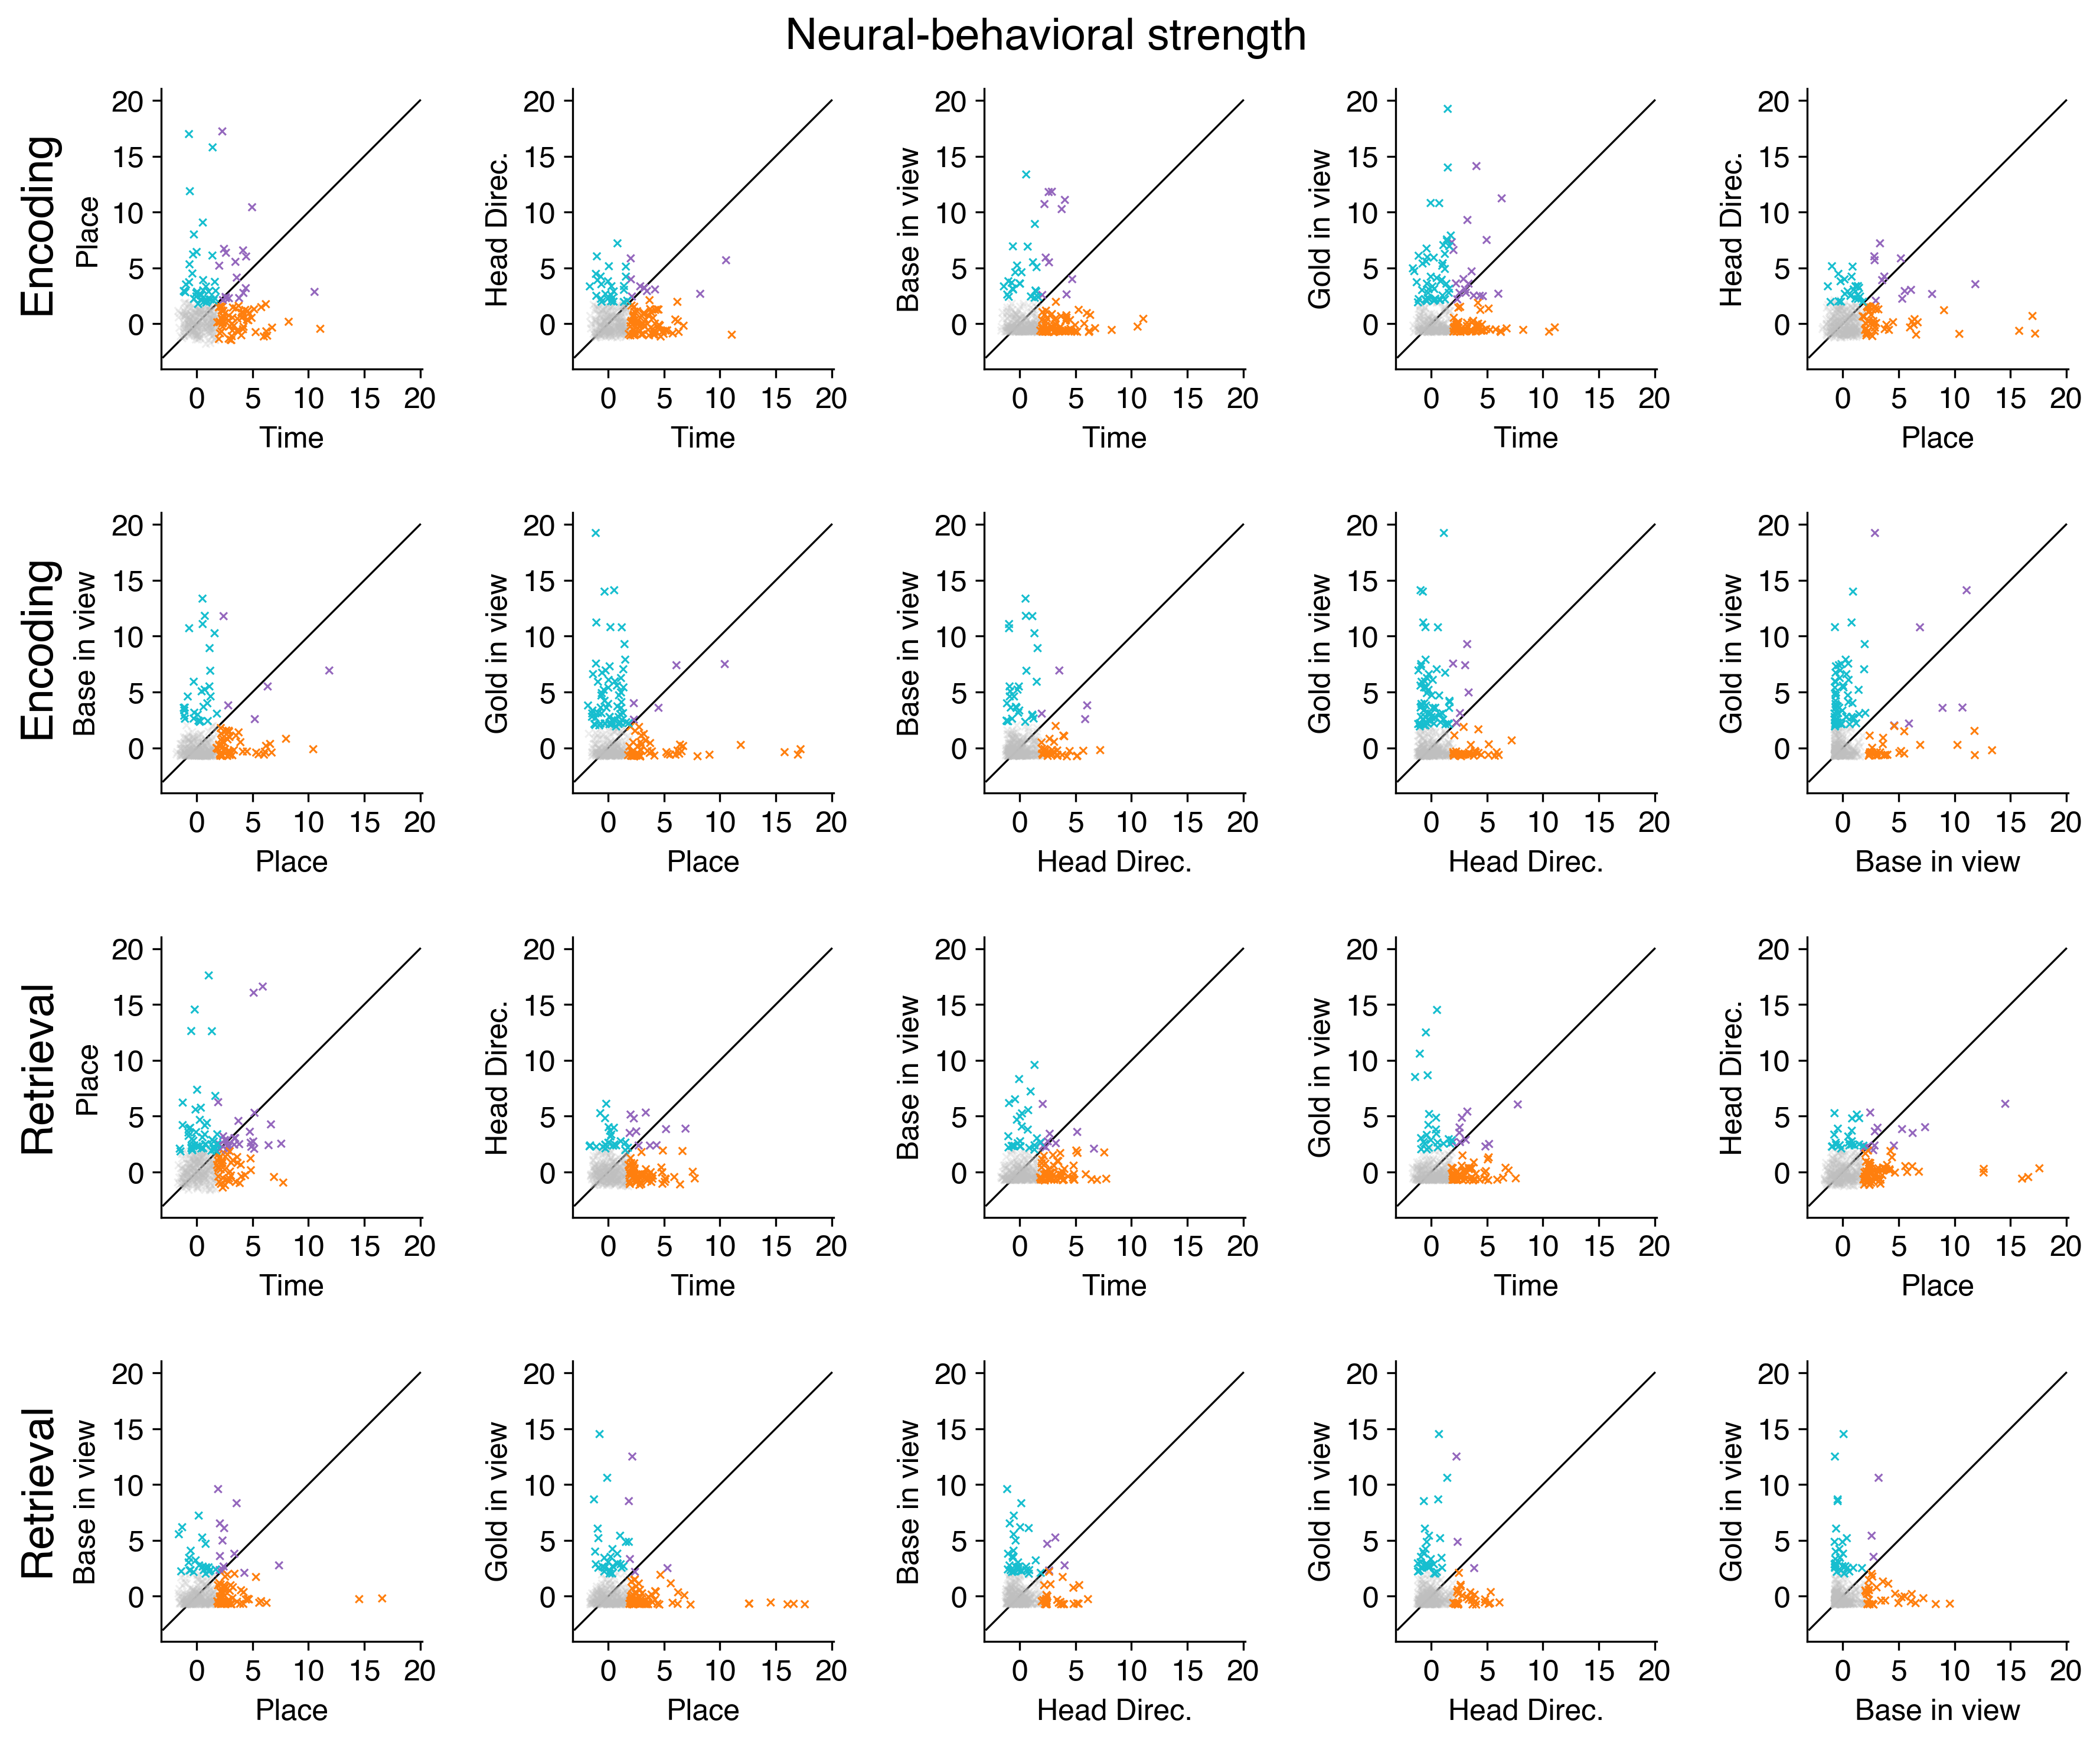

In [796]:
# Plot Z-scored likelihood rateios for Delay1 vs Delay2 time.
fig, ax = plt.subplots(4, 5, figsize=(12, 9.6), dpi=300)
ax = np.ravel(ax)

font = {'tick': 12, 'label': 12, 'annot': 12, 'fig': 16}
fancy_labels = {'time': 'Time',
                'place': 'Place',
                'head_direc': 'Head Direc.',
                'base_in_view': 'Base in view',
                'gold_in_view': 'Gold in view'}
iax = 0
vmin = -3
vmax = 20
for game_state in ['Encoding', 'Retrieval']:
    for tv1, tv2 in testvar_pairs:
        _df = param_strength.query("(gameState=='{}') & (testvar1=='{}') & (testvar2=='{}')".format(game_state, tv1, tv2))
        _df = _df.query("(zlr1<{}) & (zlr2<{})".format(vmax, vmax))
#         vmin = np.floor(np.min(_df.dropna()[['zlr1', 'zlr2']].to_numpy())) - 1
#         vmax = np.ceil(np.max(_df.dropna()[['zlr1', 'zlr2']].to_numpy())) + 1
#         print(vmin, vmax)
    #     rho, pval = stats.spearmanr(_df.query("(sig_state!=0)")['zlr1'], _df.query("(sig_state!=0)")['zlr2'])
    #     print(rho, pval)
        ax[iax].plot(np.arange(vmin, vmax+1), np.arange(vmin, vmax+1), color='k', lw=0.8, zorder=0)
        ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', alpha=0.25, lw=0.4, marker='x',
                                  edgecolor='k', palette=_cmap[:1], legend=False, 
                                  data=_df.query("(sig_state==0)"), ax=ax[iax])
        ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', alpha=1, lw=0.8, marker='x',
                                  edgecolor='k', palette=_cmap[1:], legend=False, 
                                  data=_df.query("(sig_state!=0)").sort_values('sig_state'), ax=ax[iax])
        ax[iax].set_aspect('equal', 'datalim')
        ax[iax].margins(0.1)
        ax[iax].set_xlim([vmin, vmax])
        ax[iax].set_ylim(ax[iax].get_xlim())
        ax[iax].tick_params(labelsize=font['tick'])
        ax[iax].set_xticks(np.linspace(0, 20, 5))
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_xlabel(fancy_labels[tv1], fontsize=font['label'], labelpad=5)
        ax[iax].set_ylabel(fancy_labels[tv2], fontsize=font['label'], labelpad=4)
    #     ax[iax].annotate(r'$\rho = {:.2f}$'.format(rho), (0.1, 0.85), 
    #                      xycoords='axes fraction', color='k', fontsize=font['tick']-2)
        if (iax % 5) == 0:
            ax[iax].annotate(game_state, (-0.55, 0.74), xycoords='axes fraction', rotation=90, fontsize=font['fig'] + 2)
        iax += 1
    
fig.suptitle('Neural-behavioral strength', fontsize=font['fig'] + 2, y=1.02)
fig.set_facecolor('w')
fig.tight_layout(w_pad=2, h_pad=2)
fig.show()

In [805]:
keep_cols = ['gameState', 'testvar', 'reduced', 'full', 'llf_full', 'lr', 'z_lr', 'df', 'emp_pval', 'sig05']
ols_pairs.pivot('subj_sess_unit', '')

Index(['subj_sess_unit', 'subj_sess', 'neuron', 'gameState', 'testvar',
       'reduced', 'full', 'llf_full', 'lr', 'z_lr', 'df', 'params_full',
       'chi_pval', 'emp_pval', 'null_hist', 'icpt', 'time-2', 'sig05',
       'sig025', 'sig0125', 'sig005', 'time-3', 'time-4', 'time-5', 'time-6',
       'time-7', 'time-8', 'time-9', 'time-10', 'place-C_Hall',
       'place-NE_Hall', 'place-NE_Room', 'place-NW_Hall', 'place-NW_Room',
       'place-N_Passage', 'place-SE_Hall', 'place-SE_Room', 'place-SW_Hall',
       'place-SW_Room', 'place-S_Passage', 'hd-N', 'hd-S', 'hd-W', 'is_moving',
       'base_in_view', 'gold_in_view', 'dig_performed', 'trial-10', 'trial-11',
       'trial-12', 'trial-13', 'trial-14', 'trial-15', 'trial-16', 'trial-17',
       'trial-18', 'trial-19', 'trial-20', 'trial-21', 'trial-22', 'trial-23',
       'trial-24', 'trial-25', 'trial-26', 'trial-27', 'trial-28', 'trial-29',
       'trial-2', 'trial-30', 'trial-31', 'trial-32', 'trial-33', 'trial-34',
       'trial-3

**Goal:** Create the events.event_behav DataFrame for each testing session, to be initialized within Events.__init__(subj_sess). This df contains every 500ms interval from Delay1, Encoding, ReturnToBase1, Delay2, Retrieval, and ReturnToBase2 trial phases for a given session. Each row represents exactly 500ms of data. Remainder intervals (<500ms) at the end of each trial phase are not included.

1. subj : str, e.g. “U530”
2. sess : int, 0 for the first session, 1 for the second, etc.
3. trial : int, starts at 1 and increments to 36 if all trials were completed
4. time_penalty: int, 1 if the current trial has a time penalty, 0 otherwise
5. gameState : str, will be Delay1, Encoding, ReturnToBase1, Delay2, Retrieval, or ReturnToBase2
6. start_time : int, start time for the time bin in ms. Values come from events.events[‘time’]
7. stop_time : int, stop time for the time bin in ms. Should equal the start_time + 500, and should be the same as the start time for the next time bin if the next time bin has the same game_state
8. time_bin : int, 0 for the first 500ms for a given game_state, 1 for 500-1000ms, ...
9. time_step : int, the time step for a given game_state. 1 time step = 1+ time bins, consistent within a given game_state.
10. maze_region : str, the maze region where the subject spent the most time within a given time bin, among the 12 unique maze regions, e.g. ‘Base’, ‘S Passage’, …, ‘SW Hall’. Value is ‘Base’ during Delay1 and Delay2
11. head_direc : str, will be ‘N’, ‘S’, ‘E’, or ‘W’ depending on the dominant head_direction that the subject faced for a given time bin. see my function head_direction() to get this info from ‘rotationY’ within events.events.query(“(key==‘playerTransform’)“)[‘value’]. Value should be ‘N’ during Delay1 and Delay2
12. is_moving : int, 1 if there was any change in optic flow within a given time bin (i.e. change in position or head rotation), 0 otherwise. Value should be 0 during Delay1 and Delay2
13. base_in_view : int, 1 if the base was viewed at any time within a given time bin, 0 otherwise. Value should be 1 during Delay1 and Delay2
14. gold_in_view : int, 1 if a gold item was viewed at any time within a given time bin, 0 otherwise. These values come from events.events.query(“(key==‘goldInView’)“)[‘value’].apply(lambda x: x[‘inView’]). Value should be 0 outside of Encoding and Retrieval
15. gold_in_view_ids : tuple(str), unique IDs for the 1+ gold items that were viewed within a given time bin. The order of these IDs doesn’t matter. These IDs come from events.events.query(“(key==‘goldInView’)“)[‘value’].apply(lambda x: x[‘reportingId’]). Value should be np.nan if gold_in_view==0
16. dig_performed : 1 if 1+ dig actions were performed within a given time bin, 0 otherwise. Value should be 0 outside of Retrieval
17. dig_success : 1 if any digs were successful within a given time bin, 0 otherwise. Value should be np.nan if dig_performed==0
18. all_digs : tuple(int), a tuple of dig outcomes for each dig that was performed within a given time bin. all_digs[0] gives the outcome of the first dig, all_digs[1] gives the outcome for the second dig, etc. Outcome is 1 if the dig was successful and 0 otherwise. Values come from events.events.query(“(key==‘dig’)“)[‘value’].apply(lambda x: x[‘successful’]). Value should be np.nan if dig_performed==0
19. dig_ids : tuple(str), a tuple of unique IDs to the nearest gold for each dig that the subject performed within a given time bin. dig_ids[0] should give the ID of the closest gold to the location where all_digs[0] was performed, dig_ids[1] should give the ID for the closest gold to the location where all_digs[1] was performed, etc. The location where each dig occurred is given by events.events.query(“(key==‘dig’)“)[‘value’].apply(lambda x: (x[‘nearestGoldPositionX’], x[‘nearestGoldPositionZ’])). To figure out the gold IDs that correspond to these locations, you’ll have to compare each nearestGoldPositionX to the positions where gold was spawned on a given trial, which you can get from events.events.query(“(trial==some_trial_number) & (key==‘goldLocation’)“)[‘value’]. Value should be np.nan if dig_performed==0
20. dig_dists : tuple(float), a tuple of Euclidean distances to the nearest gold for each dig that the subject performed within a given time bin. dig_dists[0] should give the distance to the nearest gold from the location where all_digs[0] was performed, dig_dists[1] should give the distance to the nearest gold from the location where all_digs[1] was performed, etc. The distances from nearest gold are given by events.events.query(“(key==‘dig’)“)[‘value’].apply(lambda x: x[‘distanceFromNearestGold’]). Value should be np.nan if dig_performed==0

In [41]:
_events.positions.groupby('gameState').agg({'gameState': len,
                                            'trial': lambda x: len(np.unique(x)),
                                            'dur': lambda x: '{:.0f} s'.format(np.sum(x) * 1e-3),
                                            'speed': lambda x: '{:.0%} moving; median = {:.1f}m/s'.format(np.mean(x!=0), np.median(x[x>0])),
                                            #'maze_region': lambda x: np.unique(x, return_counts=True),
                                            'head_direc': lambda x: np.unique(x, return_counts=True),
                                            'moved_pos': lambda x: '{} ({:.0%})'.format(np.sum(x), np.mean(x)),
                                            'moved_region': lambda x: '{} ({:.0%})'.format(np.sum(x), np.mean(x)),
                                            'moved_rot': lambda x: '{} ({:.0%})'.format(np.sum(x), np.mean(x)),
                                            'moved_hd': lambda x: '{} ({:.0%})'.format(np.sum(x), np.mean(x))})

gameState  trial    dur                        speed  \
gameState                                                             
Encoding           19755     33  991 s  66% moving; median = 4.0m/s   
Retrieval          19776     33  990 s  59% moving; median = 4.0m/s   
ReturnToBase1       1128     12   57 s  85% moving; median = 4.0m/s   
ReturnToBase2        628      6   31 s  83% moving; median = 4.0m/s   

                                             head_direc    moved_pos  \
gameState                                                              
Encoding       ([E, N, S, W], [4667, 6339, 3545, 5204])  13071 (66%)   
Retrieval      ([E, N, S, W], [4081, 5529, 5109, 5057])  11743 (59%)   
ReturnToBase1       ([E, N, S, W], [304, 28, 484, 312])    955 (85%)   
ReturnToBase2       ([E, N, S, W], [191, 17, 283, 137])    522 (83%)   

              moved_region    moved_rot  moved_hd  
gameState                                          
Encoding          272 (1%)  11204 (57%)  477 (2%)  
Retrieval         247 (1%)   9569 (48%)  336 (2%)  
ReturnToBase1      17 (2%)    741 (66%)   31 (3%)  
ReturnToBase2      13 (2%)    460 (73%)   16 (3%)

In [ ]:
for subj_sess in sessions:
    _events = events[subj_sess]
    print(subj_sess)
    display(_events.events_behav.groupby('gameState').agg(
        {'subj': len,
         'trial': lambda x: len(np.unique(x)),
         'head_direc': lambda x: np.unique(x, return_counts=True),
         'is_moving': lambda x: '{} ({:.0%})'.format(np.nansum(x), np.nanmean(x)),
         'base_in_view': lambda x: '{} ({:.0%})'.format(np.nansum(x), np.nanmean(x)),
         'gold_in_view': lambda x: '{} ({:.0%})'.format(np.nansum(x), np.nanmean(x)),
         'dig_performed': lambda x: '{} ({:.0%})'.format(np.nansum(x), np.nanmean(x)),
         'dig_success': lambda x: '{} ({:.0%})'.format(np.nansum(x), np.nanmean(x))}))
    print()